In [9]:
import numpy as np
import polars as pl
import polars.selectors as cs
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import pandas as pd
import pandas as pd, numpy as np, re

# Prétraitement & vues multi-résolution

## Récupération de la donnée / Filtrage

Avant d’appliquer le pipeline de prétraitement (dé-trending spline/GP, sigma-clipping 5σ, normalisation médiane / IQR, uniformisation de cadence), il faut savoir où sont le temps, le flux, et les flags dans le CSV. 

Comment faire ?

Création d'une pipeline générique. Nous allons créer un dictionnaire pour rendre la recherche insensible à la casse (ex : "time"->"TIME").
Puis comme les CSV astronomiques n'ont pas tous les mêmes entêtes on augmentente la robustesse en récupéreant les colonnes par mot clés.



## Dé-trending longue échelle 

### Aides statistiques robustes
Objectif : obtenir une courbe propre, centrée, régulière, où les petites baisses utiles ne sont pas écrasées.

Def mad (Médian absolute deviation) et IQR (écart interquartile) : ignorent l'influence des gros pics avec une dispersion basées sur les quantiles
(permet de garder un seuil réaliste pour repérer les vrais point anormaux )

Def robust_sigma : Sert à traduire MAD en “σ” robuste compatible. 
/!\ 1,4826 = 1 / 0,6745 
donc 1,4826 * 0,6745  ≈  1 

A savoir 1,4826 est une constante théorique qui vient de la loi normale standard ;)
(permet de corrigé la mad pour qu'il soit "équivalent à un écart type classique)

### Sigma-clipping itératif

In [10]:
# ============================================
# TESS Light Curve — Detrend & Cleaning & Resampling (Kaggle-ready)
# ============================================
import numpy as np, pandas as pd, warnings
from dataclasses import dataclass
from typing import Tuple, Optional, Dict, List
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ---------- Utils ----------
def infer_time_flux_columns(df: pd.DataFrame,
                            prefer_time: str | None = None,
                            prefer_flux: str | None = None) -> tuple[str, str]:
    """
    Infère les colonnes temps/flux.
    - Reconnaît les variantes TESS/Kepler: time_bjd_tdb, btjd/tbjd/bkjd/bjd/jd/mjd/time, etc.
    - Flux: flux_norm, pdcsap_flux, sap_flux, flux, flux_raw/flux_corrected, f...
    - Si prefer_* fourni et présent, il est utilisé en priorité.
    - Fallback: 1) colonnes dont le nom contient 'time' / 'flux' et dtype numérique
               2) tentative sur colonnes numériques uniques proches.
    """
    cols = {c.lower(): c for c in df.columns}
    # 1) préférences explicites
    if prefer_time and prefer_time in df.columns:
        time_col = prefer_time
    else:
        time_candidates = [
            # très usuels TESS/Kepler
            "time_bjd_tdb", "btjd", "tbjd", "bkjd", "bjd", "jd", "mjd",
            # génériques
            "time", "t",
            # variantes vues parfois
            "time_mission", "time_btjd", "time_bkjd", "time_bjd", "time_jd"
        ]
        time_col = next((cols[c] for c in time_candidates if c in cols), None)

    if prefer_flux and prefer_flux in df.columns:
        flux_col = prefer_flux
    else:
        flux_candidates = [
            # usuels
            "flux_norm", "pdcsap_flux", "sap_flux", "flux",
            # variantes fréquentes
            "flux_corrected", "flux_raw", "f", "flux_cal", "flux_det", "flux_lc"
        ]
        flux_col = next((cols[c] for c in flux_candidates if c in cols), None)

    # 2) Fallback par motif + dtype numérique
    def _first_numeric_col_containing(substr: str):
        for c in df.columns:
            if substr in c.lower():
                try:
                    if pd.api.types.is_numeric_dtype(df[c]):
                        return c
                except Exception:
                    continue
        return None

    if time_col is None:
        time_col = _first_numeric_col_containing("time")
    if flux_col is None:
        flux_col = _first_numeric_col_containing("flux")

    # 3) Erreur si toujours rien
    if time_col is None or flux_col is None:
        raise ValueError(f"Impossible d'inférer time/flux. Colonnes vues: {list(df.columns)[:10]}")

    return time_col, flux_col


# ---------- Sigma clipping robuste ----------
def robust_sigma_clip(y: np.ndarray, sigma: float = 5.0) -> np.ndarray:
    """
    Renvoie un masque True pour les points conservés, False pour outliers.
    Estimation robuste via médiane + MAD (IQR-like).
    """
    med = np.nanmedian(y)
    mad = np.nanmedian(np.abs(y - med))
    if mad == 0 or np.isnan(mad):
        # fallback std
        std = np.nanstd(y)
        z = (y - np.nanmean(y)) / (std if std > 0 else 1)
    else:
        # 1.4826 ~ factor to make MAD comparable to std under normality
        z = (y - med) / (1.4826 * mad)
    keep = np.isfinite(z) & (np.abs(z) <= sigma)
    return keep

# ---------- Binning pour tendance lente ----------
def bin_median(x: np.ndarray, y: np.ndarray, bin_width_days: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Binning médian pour capturer la tendance de fond sur une échelle donnée (bin_width_days).
    """
    if len(x) == 0:
        return x, y
    x0, x1 = np.nanmin(x), np.nanmax(x)
    if not np.isfinite(x0) or not np.isfinite(x1) or x1 <= x0:
        return x, y
    edges = np.arange(x0, x1 + bin_width_days, bin_width_days)
    idx = np.digitize(x, edges) - 1
    xb, yb = [], []
    for i in range(len(edges)-1):
        m = idx == i
        if m.sum() >= 3:
            xb.append(np.nanmedian(x[m]))
            yb.append(np.nanmedian(y[m]))
    return np.array(xb), np.array(yb)

# ---------- Tendance par spline cubique ----------
def fit_spline_trend(time: np.ndarray, flux: np.ndarray,
                     bin_width_hours: float = 6.0,
                     spline_smooth_factor: Optional[float] = None) -> np.ndarray:
    """
    Estime la tendance lente via:
    1) bin médian (par ex. 6h) pour lisser le bruit haute fréquence,
    2) spline cubique lissée (UnivariateSpline, k=3) ajustée sur ces points binnés,
    3) évalue la spline aux temps originaux.
    """
    # Convertir bin en jours (TESS/Kepler: temps en jours)
    bin_w_days = bin_width_hours / 24.0
    xb, yb = bin_median(time, flux, bin_w_days)

    if len(xb) < 5:
        # Pas assez de points binned -> fallback à une spline directe (ou médiane)
        med = np.nanmedian(flux)
        return np.full_like(flux, med)

    # Choix d'un facteur de lissage raisonnable s si non fourni
    # s ~ lambda * N, où lambda ~ variance résiduelle attendue
    # On met un s par défaut conservatif (proportionnel à nb de points binnés).
    if spline_smooth_factor is None:
        spline_smooth_factor = max(1e-3, 0.001 * len(xb))

    try:
        spl = UnivariateSpline(xb, yb, k=3, s=spline_smooth_factor)
        trend = spl(time)
    except Exception:
        # Fallback: moyenne mobile grossière (au cas où spline échoue)
        trend = pd.Series(flux).rolling(window=101, min_periods=1, center=True).median().values

    return trend

# ---------- Normalisation robuste ----------
def robust_scale(y: np.ndarray) -> np.ndarray:
    med = np.nanmedian(y)
    q25, q75 = np.nanpercentile(y, [25, 75])
    iqr = q75 - q25
    if not np.isfinite(iqr) or iqr == 0:
        iqr = np.nanstd(y)
        if not np.isfinite(iqr) or iqr == 0:
            iqr = 1.0
    return (y - med) / iqr

# ---------- Resampling uniforme ----------
def resample_uniform(time_days: np.ndarray,
                     flux: np.ndarray,
                     step_minutes: float = 10.0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Ré-échantillonne (interpolation linéaire) sur une grille régulière de pas = step_minutes.
    Gère les NaN: on interpole seulement entre bornes valides.
    """
    if len(time_days) < 3:
        return time_days, flux

    t0, t1 = np.nanmin(time_days), np.nanmax(time_days)
    if not np.isfinite(t0) or not np.isfinite(t1) or t1 <= t0:
        return time_days, flux

    dt = step_minutes / (24.0 * 60.0)
    grid = np.arange(t0, t1 + 0.5*dt, dt)

    # Masque points valides
    m = np.isfinite(time_days) & np.isfinite(flux)
    if m.sum() < 2:
        return grid, np.full_like(grid, np.nan)

    # Tri (sécurité)
    order = np.argsort(time_days[m])
    t_sorted = time_days[m][order]
    f_sorted = flux[m][order]

    # Interp linéaire
    f_grid = np.interp(grid, t_sorted, f_sorted, left=np.nan, right=np.nan)

    return grid, f_grid

# ---------- Pipeline complet pour une courbe ----------
@dataclass
class DetrendConfig:
    sigma: float = 5.0
    bin_width_hours: float = 6.0
    spline_smooth_factor: Optional[float] = None
    resample_step_minutes: float = 10.0
    divide_trend: bool = True  # True => flux_detrended = flux / trend (puis -1), sinon flux - trend

def preprocess_single_lightcurve(df_one: pd.DataFrame, time_col: str, flux_col: str,
                                 cfg: DetrendConfig) -> Dict[str, np.ndarray]:
    # Extraire
    t = df_one[time_col].astype(float).values
    f = df_one[flux_col].astype(float).values

    # 1) Sigma clipping robuste (5σ)
    keep = robust_sigma_clip(f, sigma=cfg.sigma)
    t1, f1 = t[keep], f[keep]

    # 2) Tendance lente via spline sur binned medians
    trend = fit_spline_trend(t1, f1, bin_width_hours=cfg.bin_width_hours,
                             spline_smooth_factor=cfg.spline_smooth_factor)

    # 3) Flatten: division ou soustraction de tendance
    if cfg.divide_trend:
        # éviter division par zéro
        trend_safe = np.where(np.isfinite(trend) & (trend != 0), trend, np.nanmedian(trend))
        f_flat = (f1 / trend_safe) - 1.0
    else:
        f_flat = f1 - trend

    # 4) Normalisation robuste
    f_norm = robust_scale(f_flat)

    # 5) Resampling uniforme (10 minutes)
    t_uni, f_uni = resample_uniform(t1, f_norm, step_minutes=cfg.resample_step_minutes)

    return {
        "time_raw": t, "flux_raw": f, "mask_kept": keep,
        "time_clipped": t1, "flux_clipped": f1, "trend": trend,
        "flux_flat": f_flat, "flux_norm": f_norm,
        "time_uniform": t_uni, "flux_uniform": f_uni
    }

# ---------- Visualisation ----------
def quick_compare_plot(proc: Dict[str, np.ndarray], title: str = "", max_points: int = 100000):
    t_raw, f_raw = proc["time_raw"], proc["flux_raw"]
    t1, f1 = proc["time_clipped"], proc["flux_clipped"]
    trend = proc["trend"]
    t_uni, f_uni = proc["time_uniform"], proc["flux_uniform"]

    # downsample for speed if huge
    def thin(x, y, k=5):
        if len(x) <= max_points:
            return x, y
        step = max(1, len(x)//max_points)
        return x[::step], y[::step]

    t_raw_, f_raw_ = thin(t_raw, f_raw)
    t1_, f1_ = thin(t1, f1)
    t_uni_, f_uni_ = thin(t_uni, f_uni)

    plt.figure(figsize=(12,9))
    # A. Brut + outliers
    ax = plt.subplot(3,1,1)
    ax.plot(t_raw_, f_raw_, ".", ms=2, alpha=0.6)
    ax.set_title(f"[A] Courbe brute (avec outliers) — {title}")
    ax.set_xlabel("Temps (jours)")
    ax.set_ylabel("Flux")

    # B. Après clipping + tendance spline
    ax = plt.subplot(3,1,2)
    ax.plot(t1_, f1_, ".", ms=2, alpha=0.6, label="Clippé (5σ)")
    # évaluer la trend sur t1_ pour overlay propre
    try:
        # Interp de la tendance pour l'affichage
        tr_disp = np.interp(t1_, t1, trend, left=np.nan, right=np.nan)
        ax.plot(t1_, tr_disp, "-", lw=1.5, label="Tendance (spline)")
    except Exception:
        pass
    ax.set_title("[B] Outliers retirés + tendance lente estimée")
    ax.set_xlabel("Temps (jours)"); ax.set_ylabel("Flux")
    ax.legend(loc="best")

    # C. Flatten + normalisé + ré-échantillonné
    ax = plt.subplot(3,1,3)
    ax.plot(t_uni_, f_uni_, ".", ms=2, alpha=0.7, label="Flatten+Norm+Uniform(10min)")
    ax.set_title("[C] Dé-trend + normalisation (médiane/IQR) + cadence uniforme")
    ax.set_xlabel("Temps (jours)"); ax.set_ylabel("Flux normalisé")
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()

# ---------- Chargement & dispatch multi-cibles ----------
def load_tess_csv(path: str, n_rows: Optional[int] = None) -> pd.DataFrame:
    # lecture flexible (le séparateur peut être comma ou autre)
    try:
        return pd.read_csv(path, nrows=n_rows)
    except Exception:
        return pd.read_csv(path, nrows=n_rows, engine="python", sep=None)

def infer_id_column(df: pd.DataFrame) -> Optional[str]:
    candidates = [
        "target_id","tic","tic_id","ticid",     # TESS
        "kepid","kic","epic",                   # Kepler/K2
        "object_id","object","source_id","star_id","gaia_source_id","id"
    ]
    cols_lower = {c.lower(): c for c in df.columns}
    for key in candidates:
        if key in cols_lower:
            return cols_lower[key]

    # Fallback: choose a non-time/flux column with reasonable cardinality
    for c in df.columns:
        cl = c.lower()
        if any(k in cl for k in ["time","flux","err","error","unc","mag","cadence"]):
            continue
        nunique = df[c].nunique(dropna=True)
        if 1 < nunique < 0.5 * len(df):
            return c
    return None

def group_iter(df: pd.DataFrame) -> List[Tuple[str, pd.DataFrame]]:
    id_col = infer_id_column(df)
    try:
        time_col, _ = infer_time_flux_columns(df)
    except Exception:
        time_col = None

    if id_col is None:
        sub = df if time_col is None else df.sort_values(time_col)
        return [("no_id", sub)]

    groups = []
    for gid_val, sub in df.groupby(id_col, sort=False):
        sub_sorted = sub if time_col is None else sub.sort_values(time_col)
        groups.append((f"{id_col}={gid_val}", sub_sorted))
    return groups


In [ ]:
# -------- Exemple : charger, traiter 3 cibles, afficher avant/après --------
input_path = "./data/TESS_standardized_lightcurves.csv"  # <- adapte si besoin
df = load_tess_csv(input_path)

time_col, flux_col = infer_time_flux_columns(df)
print("Colonnes détectées:", time_col, "|", flux_col)

cfg = DetrendConfig(
    sigma=5.0,               # clipping robuste 5σ (pics isolés)
    bin_width_hours=6.0,     # binning 6h pour la tendance lente
    spline_smooth_factor=None, # laisse l'auto-choix raisonnable
    resample_step_minutes=10.0, # cadence uniforme 10 minutes
    divide_trend=True        # flux/Trend - 1 (flatten multiplicatif)
)

for i, (gid, sub) in enumerate(group_iter(df)):
    if i >= 3: break  # démontre sur 3 cibles
    print(f"\n=== Traitement {gid} ===")
    proc = preprocess_single_lightcurve(sub.sort_values(time_col), time_col, flux_col, cfg)
    quick_compare_plot(proc, title=gid)


FileNotFoundError: [Errno 2] No such file or directory: '/data/TESS_standardized_lightcurves.csv'

## Détection de périodes candidates

In [ ]:
# ==========================================================
# BLS Period Search (candidats de périodes) — Kaggle-ready
# S'appuie sur les sorties du prétraitement:
#   t = proc["time_uniform"] (jours), y = proc["flux_uniform"] (sans tendance, normalisé)
# Nécessite: astropy (installé sur Kaggle par défaut; sinon pip install astropy)
# ==========================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
warnings.filterwarnings("ignore")
from astropy.timeseries import BoxLeastSquares


def _finite_mask(*arrs):
    m = np.ones_like(arrs[0], dtype=bool)
    for a in arrs:
        m &= np.isfinite(a)
    return m

def estimate_period_bounds(t_days: np.ndarray, min_hours: float = 7.0, max_frac_baseline: float = 0.9):
    """
    Heuristique simple:
    - période min ~ 7 h (évite d'ajuster le bruit haute fréquence)
    - période max ~ 90% de la base temporelle (évite d'atteindre le bord)
    """
    baseline_days = np.nanmax(t_days) - np.nanmin(t_days)
    p_min = max(min_hours / 24.0, 0.05)                # >= 0.05 j (≈1.2 h) en ultime secours
    p_max = max(p_min * 2, baseline_days * max_frac_baseline)
    return p_min, p_max, baseline_days

def duration_grid_hours(min_h=1.0, max_h=12.0, n=10):
    """Durées de transit testées par BLS (en heures → converties en jours)."""
    durs_h = np.geomspace(min_h, max_h, n)
    return durs_h / 24.0

def run_bls_on_proc(proc: dict,
                    n_periods: int = 5000,
                    min_period_hours: float = 7.0,
                    max_period_frac_baseline: float = 0.9,
                    durations_hours: tuple = (1.0, 12.0),
                    n_durations: int = 10,
                    top_k: int = 3):
    """
    Lance BLS (astropy) sur une courbe déjà détrendée/normalisée/ré-échantillonnée.
    Retourne dict avec:
      - 'results': DataFrame top_k candidats (period, t0, duration, depth, power, snr-like)
      - 'bls': l'objet BLS
      - 'periodogram': dict avec arrays pour plot (period, power, duration_opt, t0_opt)
    """
    t = np.asarray(proc["time_uniform"])
    y = np.asarray(proc["flux_uniform"])
    m = _finite_mask(t, y)
    t, y = t[m], y[m]

    if len(t) < 100 or (np.nanmax(t) - np.nanmin(t)) <= 0:
        raise ValueError("Série trop courte ou dégénérée pour BLS.")

    # Borne de période
    pmin, pmax, baseline_days = estimate_period_bounds(t, min_hours=min_period_hours,
                                                       max_frac_baseline=max_period_frac_baseline)
    # Durées testées
    durs = duration_grid_hours(min_h=durations_hours[0], max_h=durations_hours[1], n=n_durations)

    # Astropy BLS
    bls = BoxLeastSquares(t, y)
    # On utilise autopower (grille de fréquences implicite) avec nos durées
    power = bls.autopower(durs, minimum_period=pmin, maximum_period=pmax, objective='snr')

    # Récupère le pic principal et quelques suivants
    # Tri des indices par 'power.power' décroissant
    order = np.argsort(power.power)[::-1]
    top_idx = order[:max(1, top_k)]

    rows = []
    for idx in top_idx:
        P = power.period[idx]
        dur = power.duration[idx]
        t0 = power.transit_time[idx]
        powv = power.power[idx]

        # Raffinement local autour de ce candidat
        model = bls.model(t, P, dur, t0)
        depth = np.nanmedian(y - model)  # estimation grossière; on fait mieux via fit()
        # Fit précis (recalcule t0, depth, duration)
        try:
            fit = bls.fit(P, dur, t0)
            t0_ref, dur_ref, depth_ref = fit['transit_time'], fit['duration'], fit['depth']
            snr_ref = fit.get('depth_snr', np.nan)
            dur, t0, depth, snr_like = dur_ref, t0_ref, depth_ref, snr_ref
        except Exception:
            snr_like = powv  # fallback

        rows.append(dict(
            period=P, duration=dur, t0=t0, depth=depth, power=powv, snr=snr_like
        ))

    results = pd.DataFrame(rows).sort_values(
        by=["snr","power"], ascending=False
    ).reset_index(drop=True)

    # Détection “single-transit-like” (heuristique):
    # si la meilleure période est > ~70% de la baseline, fort risque single-transit
    single_like = False
    if len(results):
        if results.loc[0, "period"] > 0.7 * baseline_days:
            single_like = True

    return {
        "results": results,
        "bls": bls,
        "periodogram": {
            "period": power.period,
            "power": power.power,
            "duration_opt": power.duration,
            "t0_opt": power.transit_time,
            "pmin": pmin, "pmax": pmax, "baseline_days": baseline_days,
            "single_transit_like": single_like
        }
    }

def plot_bls_periodogram(bls_out: dict, top_n: int = 1, title: str = ""):
    per = bls_out["periodogram"]["period"]
    powv = bls_out["periodogram"]["power"]
    pmin, pmax = bls_out["periodogram"]["pmin"], bls_out["periodogram"]["pmax"]
    single_like = bls_out["periodogram"]["single_transit_like"]

    res = bls_out["results"].copy()

    plt.figure(figsize=(10,5))
    plt.plot(per, powv, lw=1)
    if len(res):
        for i in range(min(top_n, len(res))):
            P = res.loc[i, "period"]
            plt.axvline(P, ls="--", alpha=0.6)
    plt.xlim(pmin, pmax)
    plt.xlabel("Période (jours)"); plt.ylabel("Puissance (objective='snr')")
    ttl = "[BLS] Periodogram"
    if single_like: ttl += " — (single-transit-like ?)"
    if title: ttl += f" — {title}"
    plt.title(ttl)
    plt.tight_layout(); plt.show()

def plot_phase_fold(proc: dict, bls_out: dict, k: int = 0, title: str = ""):
    """Affiche la courbe pliée sur la période candidate k et le modèle en boîte."""
    if len(bls_out["results"]) == 0:
        print("Pas de candidat BLS.")
        return
    P = bls_out["results"].loc[k, "period"]
    t0 = bls_out["results"].loc[k, "t0"]
    dur = bls_out["results"].loc[k, "duration"]

    t = np.asarray(proc["time_uniform"]); y = np.asarray(proc["flux_uniform"])
    m = _finite_mask(t, y); t, y = t[m], y[m]

    # Phase folding dans [-0.5, 0.5)
    phase = ((t - t0 + 0.5 * P) % P) / P - 0.5

    # Modèle en boîte pour overlay
    bls = bls_out["bls"]
    model = bls.model(t, P, dur, t0)

    # Bin de la courbe pliée pour lisser le bruit
    nbins = 200
    bins = np.linspace(-0.5, 0.5, nbins+1)
    idx = np.digitize(phase, bins) - 1
    ph_b, y_b = [], []
    for i in range(nbins):
        m = idx == i
        if m.sum() >= 5:
            ph_b.append(np.nanmedian(phase[m]))
            y_b.append(np.nanmedian(y[m]))
    ph_b, y_b = np.array(ph_b), np.array(y_b)

    plt.figure(figsize=(10,5))
    plt.plot(phase, y, ".", ms=2, alpha=0.25, label="Pliée (points)")
    if len(ph_b):
        plt.plot(ph_b, y_b, "-", lw=1.5, label="Pliée (binned médian)")
    # Overlay du modèle: on doit aussi le plier
    phase_m = ((t - t0 + 0.5 * P) % P) / P - 0.5
    # On bin le modèle comme la courbe
    idxm = np.digitize(phase_m, bins) - 1
    mod_b = []
    for i in range(nbins):
        m = idxm == i
        if m.sum() >= 5:
            mod_b.append(np.nanmedian(model[m]))
    if len(mod_b) == len(y_b):
        plt.plot(ph_b, mod_b, "-", lw=2, alpha=0.9, label="Modèle BLS")

    plt.xlabel("Phase (cycles)"); plt.ylabel("Flux normalisé")
    ttl = f"[BLS] Fold P={P:.5f} j, dur={dur*24:.2f} h"
    if title: ttl += f" — {title}"
    plt.title(ttl)
    plt.legend()
    plt.tight_layout(); plt.show()


In [ ]:
# === Cellule de vérification BLS (safe) : calcule P et évite l'erreur durée > période ===
# Hypothèses: 'proc' (prétraité), 'estimate_period_bounds', 'run_bls_on_proc' existent déjà.

# 1) Estimer les bornes de période avec la même heuristique que BLS
t_uni = np.asarray(proc["time_uniform"])
pmin, pmax, baseline_days = estimate_period_bounds(t_uni, min_hours=7.0, max_frac_baseline=0.9)

# 2) Forcer une durée max < période min (contrainte astropy BLS)
max_dur_hours_safe = min(12.0, 0.8 * pmin * 24.0)  # 80% de P_min
min_dur_hours = 1.0
if max_dur_hours_safe <= min_dur_hours:
    # si la période min est trop courte, on réduit min_dur pour rester valide
    min_dur_hours = max(0.25, 0.2 * max_dur_hours_safe)

print(f"[Info] P_min ≈ {pmin:.4f} j ({pmin*24:.2f} h) | P_max ≈ {pmax:.2f} j")
print(f"[Info] Durées testées (heures): [{min_dur_hours:.2f} .. {max_dur_hours_safe:.2f}]")

# 3) Lancer BLS avec des durées sûres
bls_out = run_bls_on_proc(
    proc,
    n_periods=5000,
    min_period_hours=24.0 * pmin,              # garde cohérent avec pmin calculé (en heures)
    max_period_frac_baseline=0.9,
    durations_hours=(min_dur_hours, max_dur_hours_safe),
    n_durations=10,
    top_k=3
)

# 4) Imprimer les périodes candidates
res = bls_out["results"]
if len(res) == 0:
    print("BLS n'a retourné aucun candidat (résultats vides).")
else:
    print("\n=== Candidats BLS (Top) ===")
    for i in range(len(res)):
        P = float(res.loc[i, "period"])
        dur_h = float(res.loc[i, "duration"] * 24.0)
        snr = res.loc[i, "snr"]
        print(f"#{i+1}  P = {P:.6f} jours  ({P*24:.2f} h) | durée ~ {dur_h:.2f} h | SNR ≈ {snr:.2f}")

    if bls_out["periodogram"]["single_transit_like"]:
        print("\n[Note] Le meilleur P est proche de la durée de base : cas 'single-transit-like' possible.")


[Info] P_min ≈ 0.2917 j (7.00 h) | P_max ≈ 24.66 j
[Info] Durées testées (heures): [1.00 .. 5.60]

=== Candidats BLS (Top) ===
#1  P = 1.866987 jours  (44.81 h) | durée ~ 1.20 h | SNR ≈ 13.63
#2  P = 1.867374 jours  (44.82 h) | durée ~ 1.20 h | SNR ≈ 13.53
#3  P = 1.867568 jours  (44.82 h) | durée ~ 1.20 h | SNR ≈ 13.53


## Construction des vues multi-résolution

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Utils: resampling sur N points fixes ----------
def _resample_to_fixed_length(x, y, n_points=2001):
    """Interpole y(x) sur une grille régulière de n_points entre min(x) et max(x)."""
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 2:
        return np.linspace(0, 1, n_points), np.full(n_points, np.nan)
    xs = np.sort(x[m])
    ys = y[m][np.argsort(x[m])]
    grid = np.linspace(xs.min(), xs.max(), n_points)
    yg = np.interp(grid, xs, ys)
    return grid, yg

def _bin_median(x, y, nbins):
    """Binning médian (utile pour réduire le bruit après pliage)."""
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if len(x) == 0:
        return np.linspace(-0.5, 0.5, nbins), np.full(nbins, np.nan)
    edges = np.linspace(x.min(), x.max(), nbins+1)
    idx = np.digitize(x, edges) - 1
    xb, yb = [], []
    for i in range(nbins):
        mask = idx == i
        if mask.sum() >= 3:
            xb.append(np.nanmedian(x[mask]))
            yb.append(np.nanmedian(y[mask]))
    if len(xb) < 2:
        # fallback interpolation simple
        grid = np.linspace(x.min(), x.max(), nbins)
        yg = np.interp(grid, x, y)
        return grid, yg
    return np.array(xb), np.array(yb)

# ---------- Extraction (P, t0, dur) à partir de bls_out ou paramètres ----------
def _pick_bls_candidate(bls_out, k=0):
    """Renvoie (P, t0, dur) en jours si disponible, sinon (None, None, None)."""
    if bls_out is None:
        return None, None, None
    res = bls_out.get("results", pd.DataFrame())
    if len(res) == 0:
        return None, None, None
    P = float(res.loc[k, "period"])
    t0 = float(res.loc[k, "t0"])
    dur = float(res.loc[k, "duration"])
    return P, t0, dur

# ---------- Construction des vues ----------
def build_multires_views(proc: dict,
                         bls_out: dict | None = None,
                         P: float | None = None,
                         t0: float | None = None,
                         dur: float | None = None,
                         N_GLOBAL: int = 2001,
                         N_LOCAL: int = 201,
                         window_factor: float = 2.0,
                         median_bin_local: bool = True):
    """
    Renvoie un dict avec:
      - 'global_time', 'global_flux' (N_GLOBAL)
      - 'fold_phase', 'fold_flux' (pliage sur P, binned à N_GLOBAL/≈2000)
      - 'local_phase', 'local_flux' (fenêtre ± window_factor*dur autour du transit, N_LOCAL)
      - 'meta': {'P','t0','dur','has_period','single_transit_like'}
    """
    # 0) Entrées
    t = np.asarray(proc["time_uniform"])
    y = np.asarray(proc["flux_uniform"])
    m = np.isfinite(t) & np.isfinite(y)
    t, y = t[m], y[m]

    views = {"meta": {}}

    # 1) Vue Globale (contexte longue durée)
    g_time, g_flux = _resample_to_fixed_length(t, y, n_points=N_GLOBAL)
    views["global_time"] = g_time
    views["global_flux"] = g_flux

    # 2) Déterminer P, t0, dur
    if P is None or t0 is None or dur is None:
        P_bls, t0_bls, dur_bls = _pick_bls_candidate(bls_out, k=0)
        if P is None:  P = P_bls
        if t0 is None: t0 = t0_bls
        if dur is None: dur = dur_bls

    single_like = False
    if bls_out is not None and "periodogram" in bls_out:
        single_like = bool(bls_out["periodogram"].get("single_transit_like", False))

    has_period = (P is not None) and (np.isfinite(P)) and (P > 0) and (dur is not None) and (dur > 0)

    views["meta"].update(dict(P=P, t0=t0, dur=dur, has_period=has_period, single_transit_like=single_like))

    # 3) Si période connue: Vue Pliée + Vue Locale
    if has_period:
        # 3a) Pliage en phase dans [-0.5, 0.5)
        phase = ((t - t0 + 0.5 * P) % P) / P - 0.5

        # Pliée "globale" (pour visualisation): binned médian ~ 2000 points
        fold_n = min(2000, max(200, N_GLOBAL))  # nombre raisonnable
        if median_bin_local:
            ph_b, y_b = _bin_median(phase, y, nbins=fold_n)
        else:
            # simple interpolation sur grille régulière de phase
            grid = np.linspace(-0.5, 0.5, fold_n)
            order = np.argsort(phase)
            ph_sorted, y_sorted = phase[order], y[order]
            y_interp = np.interp(grid, ph_sorted, y_sorted)
            ph_b, y_b = grid, y_interp

        views["fold_phase"] = ph_b
        views["fold_flux"]  = y_b

        # 3b) Vue Locale (fenêtre centrée sur transit principal)
        # Largeur fenêtre en phase = (window_factor * dur) / P
        half_width_phase = float(window_factor * dur / P)  # typiquement ~ 2*dur/P
        # Borner pour rester dans l'intervalle de phase
        half_width_phase = float(min(0.45, max(0.01, half_width_phase)))

        sel = (phase >= -half_width_phase) & (phase <= half_width_phase)
        if sel.sum() < 10:
            # fallback: élargir un peu la fenêtre si trop peu de points
            half_width_phase = min(0.45, half_width_phase * 1.5)
            sel = (phase >= -half_width_phase) & (phase <= half_width_phase)

        ph_loc, y_loc = phase[sel], y[sel]
        if median_bin_local:
            ph_loc_b, y_loc_b = _bin_median(ph_loc, y_loc, nbins=N_LOCAL)
        else:
            # interpolation uniforme dans la fenêtre locale
            grid_loc = np.linspace(-half_width_phase, half_width_phase, N_LOCAL)
            if len(ph_loc) >= 2:
                order = np.argsort(ph_loc)
                phs, ys = ph_loc[order], y_loc[order]
                y_loc_b = np.interp(grid_loc, phs, ys)
            else:
                y_loc_b = np.full_like(grid_loc, np.nan)
            ph_loc_b = grid_loc
            
        if len(ph_loc_b) != N_LOCAL:
            if len(ph_loc_b) >= 2:
                grid_fix = np.linspace(-half_width_phase, half_width_phase, N_LOCAL)
                order = np.argsort(ph_loc_b)
                ph_sorted, y_sorted = np.asarray(ph_loc_b)[order], np.asarray(y_loc_b)[order]
                y_fix = np.interp(grid_fix, ph_sorted, y_sorted)
                ph_loc_b, y_loc_b = grid_fix, y_fix
            else:
                # trop peu de points -> on génère une fenêtre plate (zeros) pour rester aligné
                ph_loc_b = np.linspace(-half_width_phase, half_width_phase, N_LOCAL)
                y_loc_b  = np.zeros_like(ph_loc_b, dtype=float)

        views["local_phase"] = ph_loc_b
        views["local_flux"]  = y_loc_b

    else:
        # Pas de période fiable -> pas de vues pliées
        views["fold_phase"] = None
        views["fold_flux"]  = None
        views["local_phase"] = None
        views["local_flux"]  = None

    # 4) Petit résumé console
    print("[Multi-vues] Global:", len(views["global_time"]), "points",
          "| Folded:", "ok" if views["fold_phase"] is not None else "n/a",
          "| Local:", "ok" if views["local_phase"] is not None else "n/a")
    if has_period:
        print(f"[P={P:.6f} j | dur={dur*24:.2f} h | window ±{window_factor}×dur -> ±{(window_factor*dur/P):.4f} phase]")
        if single_like:
            print("[Note] Cas 'single-transit-like' détecté: P possiblement mal contrainte.")
    else:
        print("[Info] Aucune période fournie/détectée: seules les vues Globales sont produites.")

    return views

# ---------- (Optionnel) mini-plot pour contrôle visuel ----------
def plot_multires_views(views, title=""):
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    # Global
    axes[0].plot(views["global_time"], views["global_flux"], lw=1)
    axes[0].set_title("Vue Globale"); axes[0].set_xlabel("Temps (j)"); axes[0].set_ylabel("Flux")

    # Folded
    if views["fold_phase"] is not None:
        axes[1].plot(views["fold_phase"], views["fold_flux"], lw=1)
    axes[1].set_title("Vue Pliée"); axes[1].set_xlabel("Phase"); axes[1].set_ylabel("Flux")

    # Local
    if views["local_phase"] is not None:
        axes[2].plot(views["local_phase"], views["local_flux"], lw=1)
    axes[2].set_title("Vue Locale"); axes[2].set_xlabel("Phase"); axes[2].set_ylabel("Flux")
    fig.suptitle(title)
    plt.tight_layout(); plt.show()

[Multi-vues] Global: 2001 points | Folded: ok | Local: ok
[P=1.866987 j | dur=1.20 h | window ±2.0×dur -> ±0.0536 phase]


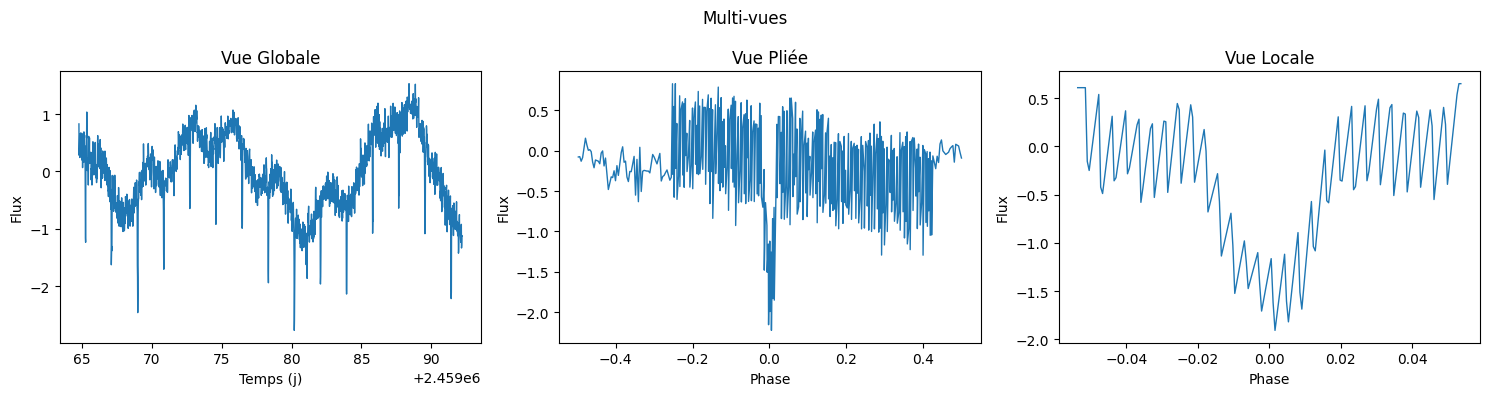

In [ ]:
# Suppose: proc existe déjà. Si bls_out existe aussi, on s'en sert pour P,t0,dur (sinon: vues globales seules).
views = build_multires_views(proc, bls_out=globals().get("bls_out", None),
                             N_GLOBAL=2001, N_LOCAL=201, window_factor=2.0)

# (optionnel) Visualisation rapide
plot_multires_views(views, title="Multi-vues")

# (B) Extraction de features TSFRESH (baseline + fusion)

In [ ]:
# ============================================
# Pipeline TSFRESH (extraction + sélection + normalisation) — Kaggle-ready
# Hypothèses:
#  - Vous avez déjà: df, cfg, infer_time_flux_columns(...), group_iter(...),
#                    preprocess_single_lightcurve(...), run_bls_on_proc(...) (optionnel)
#  - Objectif: produire un tableau de features par courbe (id de groupe),
#              y ajouter des features astrophysiques (P, dur, depth, snr) si BLS dispo,
#              puis sélectionner les top-K (optionnel, si y est fourni) et normaliser.
# ============================================
import numpy as np, pandas as pd, warnings, hashlib
warnings.filterwarnings("ignore")

# 0) Dépendances TSFRESH
try:
    from tsfresh.feature_extraction import extract_features, ComprehensiveFCParameters
    from tsfresh.utilities.dataframe_functions import impute as tsfresh_impute
    from tsfresh.feature_selection import select_features
except Exception as e:
    raise RuntimeError("TSFRESH manquant. Exécutez dans une cellule séparée: !pip -q install tsfresh")

# ---------- Utilitaires ----------
def _gid_to_int(gid: str) -> int:
    """Mappe un identifiant texte de groupe vers un entier stable (pour TSFRESH 'id')."""
    return int(hashlib.md5(gid.encode()).hexdigest()[:8], 16)

def _make_long_df_from_proc(proc: dict, gid: str) -> pd.DataFrame:
    """
    Transforme la série uniformisée d'un groupe en format long pour TSFRESH:
    colonnes: ['id','time','value']
    """
    t = np.asarray(proc["time_uniform"])
    y = np.asarray(proc["flux_uniform"])
    m = np.isfinite(t) & np.isfinite(y)
    df_long = pd.DataFrame({
        "id": _gid_to_int(gid),
        "time": t[m],
        "value": y[m]
    })
    return df_long

def _astrophys_extras_from_bls(bls_out: dict | None) -> dict:
    """
    Extrait quelques indicateurs astrophysiques élémentaires depuis BLS (si dispo).
    """
    extras = {"P": np.nan, "duration": np.nan, "depth": np.nan, "snr_bls": np.nan, "single_transit_like": np.nan}
    if bls_out is None or "results" not in bls_out or len(bls_out["results"]) == 0:
        return extras
    res0 = bls_out["results"].iloc[0]
    extras.update({
        "P": float(res0.get("period", np.nan)),
        "duration": float(res0.get("duration", np.nan)),          # jours
        "depth": float(res0.get("depth", np.nan)),
        "snr_bls": float(res0.get("snr", np.nan)),
        "single_transit_like": float(bool(bls_out["periodogram"].get("single_transit_like", False)))
    })
    return extras

# ---------- Extraction batched ----------
def tsfresh_extract_for_groups(df: pd.DataFrame,
                               cfg,
                               time_col: str | None = None,
                               flux_col: str | None = None,
                               max_groups: int = 10,
                               run_bls: bool = True,
                               bls_params: dict | None = None) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    1) Boucle sur quelques groupes (id de cible), prétraite -> proc
    2) Construit le long-DF pour TSFRESH et accumulateur de meta (astrophysique)
    3) Extrait les features (~790) via ComprehensiveFCParameters
    4) Retourne: (X_all, meta), indexé par id numérique (stable pour ce df)
    """
    if time_col is None or flux_col is None:
        time_col, flux_col = infer_time_flux_columns(df)

    long_blocks = []
    rows_meta = []

    for i, (gid, sub) in enumerate(group_iter(df)):
        if i >= max_groups:
            break
        sub = sub.sort_values(time_col)
        proc = preprocess_single_lightcurve(sub, time_col, flux_col, cfg)

        # BLS optionnel
        bls_out = None
        if run_bls:
            try:
                bp = bls_params or {}
                # === AJOUT: calcule pmin/pmax pour cette série, puis borne les durées ===
                t_uni = np.asarray(proc["time_uniform"])
                pmin, pmax, _ = estimate_period_bounds(
                    t_uni,
                    min_hours=bp.get("min_period_hours", 7.0),
                    max_frac_baseline=bp.get("max_period_frac_baseline", 0.9)
                )
                dmin_h, dmax_h_req = bp.get("durations_hours", (1.0, 12.0))
                # contrainte Astropy: max(duration) < min(period)
                dmax_h_safe = min(dmax_h_req, 0.8 * pmin * 24.0)  # 80% de P_min en heures
                if not np.isfinite(dmax_h_safe) or dmax_h_safe <= dmin_h:
                    dmax_h_safe = max(dmin_h + 0.25, dmin_h * 1.5)
        
                bls_out = run_bls_on_proc(
                    proc,
                    n_periods=bp.get("n_periods", 5000),
                    # on fixe min_period_hours d'après pmin estimé
                    min_period_hours=24.0 * pmin,
                    max_period_frac_baseline=bp.get("max_period_frac_baseline", 0.9),
                    durations_hours=(dmin_h, dmax_h_safe),
                    n_durations=bp.get("n_durations", 10),
                    top_k=bp.get("top_k", 3)
                )
            except Exception as e:
                print(f"[BLS] Skip {gid}: {e}")

                
        # Long-format pour TSFRESH
        df_long = _make_long_df_from_proc(proc, gid)
        long_blocks.append(df_long)

        # 2) >>> ICI : construire les méta-infos à partir de BLS + infos neutres
        extras = _astrophys_extras_from_bls(bls_out)
        extras.update({
            "id": _gid_to_int(gid),
            "gid": gid,
            # NOTE: preprocess_single_lightcurve ne renvoie pas 'resample_step_minutes' → on prend cfg
            "resample_step_minutes": float(getattr(cfg, "resample_step_minutes", np.nan)),
            "n_points": int(len(proc.get("time_uniform", []))),
            # (optionnel) provenance
            "period_source": "bls" if bls_out is not None and len(bls_out.get("results", [])) else "none",
        })
        rows_meta.append(extras)

    if not long_blocks:
        raise RuntimeError("Aucun groupe n'a été traité. Vérifiez vos données/paramètres.")

    long_df = pd.concat(long_blocks, ignore_index=True)
    meta_df = pd.DataFrame(rows_meta).set_index("id").sort_index()

    # TSFRESH extraction (Comprehensive)
    settings = ComprehensiveFCParameters()
    # NOTE: vous pouvez réduire la charge en supprimant des familles de features dans 'settings'
    X = extract_features(
        long_df,
        column_id="id",
        column_sort="time",
        column_value="value",
        default_fc_parameters=settings,
        disable_progressbar=True,
        n_jobs=0  # 0 => séquentiel (plus sûr sur petits kernels)
    )

    # Imputation TSFRESH (remplit NaN/Inf de manière standard)
    tsfresh_impute(X)

    # Concat meta/astro
    for col in meta_df.columns:
        X[col] = meta_df[col].reindex(X.index)

    # Index = id numérique, gardons aussi la colonne texte 'gid' pour traçabilité
    # (déjà incluse ci-dessus via meta_df["gid"])
    return X, meta_df

# ---------- Sélection supervisée (optionnelle) ----------
def tsfresh_supervised_selection(X: pd.DataFrame, y: pd.Series | pd.DataFrame,
                                 fdr_level: float = 0.05, top_k: int | None = 100) -> pd.DataFrame:
    """
    y: Series indexée par 'id' (entier) avec labels 0/1 ou multi-classes.
    - Applique la sélection TSFRESH (tests d'hypothèse + contrôle FDR).
    - Si top_k est spécifié, garde les K meilleures (par p-value croissante).
    """
    # Harmonise les index
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("y DataFrame doit avoir une seule colonne (label).")
        y = y.iloc[:, 0]
    y = y.reindex(X.index)

    X_sel = select_features(X.drop(columns=["gid"], errors="ignore"), y, fdr_level=fdr_level)
    # Ré-attacher 'gid' pour info
    if "gid" in X.columns:
        X_sel["gid"] = X["gid"]

    if top_k is not None and X_sel.shape[1] > top_k + (1 if "gid" in X_sel.columns else 0):
        # Ordre par variance (proxy simple) si p-values non accessibles ici
        non_meta_cols = [c for c in X_all.columns if c not in ("gid",)]
        var_order = X_all[non_meta_cols].var().sort_values(ascending=False).index.tolist()[:top_k]
        keep = var_order[:top_k]
        X_sel = X_sel[keep + (["gid"] if "gid" in X_sel.columns else [])]

    return X_sel

# ---------- Normalisation robuste (pour entrée MLP d'embedding) ----------
from sklearn.preprocessing import RobustScaler

def normalize_tsfresh_features(X_sel: pd.DataFrame) -> tuple[np.ndarray, list[str], RobustScaler]:
    """
    Retire 'gid' si présent, fit un RobustScaler, renvoie (X_norm, feature_names, scaler).
    """
    cols = [c for c in X_sel.columns if c != "gid"]
    scaler = RobustScaler()
    X_norm = scaler.fit_transform(X_sel[cols].values.astype(float))
    return X_norm, cols, scaler



In [ ]:
# ---------- EXEMPLE D’USAGE (extrait, mêmes variables) ----------
# 1) détecter colonnes time/flux
time_col, flux_col = infer_time_flux_columns(df)

# 2) extraire features tsfresh (sur quelques groupes pour démo)
X_all, meta = tsfresh_extract_for_groups(
    df, cfg, time_col=time_col, flux_col=flux_col,
    max_groups=5, run_bls=True,
    bls_params=dict(min_period_hours=7.0, max_period_frac_baseline=0.9,
                    durations_hours=(1.0, 12.0), n_durations=10, top_k=3)
)
print("[TSFRESH] Matrice brute:", X_all.shape, "| colonnes (extrait):", X_all.columns[:8].tolist())
print("[TSFRESH] Meta (index=id):")
display(meta.head())

# 3) (optionnel) si vous avez des labels par id (Series y: index=id -> {0,1})
# y = ...  # e.g., pd.Series(..., index=X_all.index)
# X_sel = tsfresh_supervised_selection(X_all, y, fdr_level=0.05, top_k=100)
# print("[TSFRESH] Sélection supervisée:", X_sel.shape)

# Si pas de labels pour le moment, prenez un sous-ensemble de features par variance:
num_cols = [
    c for c in X_all.columns
    if c != "gid" and pd.api.types.is_numeric_dtype(X_all[c])
]

# Sécuriser la conversion si des colonnes sont object/mixte
X_num = X_all[num_cols].apply(pd.to_numeric, errors="coerce")

top_k = 100 if len(num_cols) > 100 else len(num_cols)
var_order = X_num.var(numeric_only=True).sort_values(ascending=False).index.tolist()[:top_k]

# Reconstruire X_sel et ré-attacher 'gid' pour traçabilité
X_sel = X_num[var_order]
if "gid" in X_all.columns:
    X_sel = pd.concat([X_sel, X_all[["gid"]]], axis=1)

print(f"[TSFRESH] Sélection non supervisée ~ top-{top_k} par variance:", X_sel.shape)

# 4) Normalisation robuste pour l'entrée du MLP d'embedding (section fusion tardive)
X_norm, feat_names, scaler = normalize_tsfresh_features(X_sel)
print("[TSFRESH] X_norm prêt pour MLP d'embedding:", X_norm.shape)

# (Optionnel) Sauvegardes pour la suite (Transformer + fusion tardive)
# X_all.to_parquet("tsfresh_all.parquet")
# X_sel.to_parquet("tsfresh_selected.parquet")
# with open("tsfresh_scaler.pkl", "wb") as f:
#     import pickle; pickle.dump(scaler, f)

# NOTE Fusion tardive (implémentation à venir dans la section C):
#  - Dans votre modèle, créez un petit MLP (ex: Dense 256, dropout) qui prend X_norm (K features)
#    et produit un embedding (par ex. shape [batch, 256]).
#  - Concaténez cet embedding avec le token [CLS] (ou le pooling global) du Transformer
#    avant la tête de classification finale. Pensez à régulariser (dropout/L2) la branche tabulaire.


[TSFRESH] Matrice brute: (5, 792) | colonnes (extrait): ['value__variance_larger_than_standard_deviation', 'value__has_duplicate_max', 'value__has_duplicate_min', 'value__has_duplicate', 'value__sum_values', 'value__abs_energy', 'value__mean_abs_change', 'value__mean_change']
[TSFRESH] Meta (index=id):


,P,duration,depth,snr_bls,single_transit_like,gid,resample_step_minutes,n_points,period_source
id,,,,,,,,,
1054784497,14.306780,0.233333,0.005111,10.044530,0.0,target_id=TIC_238597883,10.0,3947,bls
1511118701,13.061843,0.233333,0.031464,11.176657,0.0,target_id=TIC_50365310,10.0,3947,bls
1632108578,1.866987,0.050000,0.000949,13.629291,0.0,target_id=TIC_124709665,10.0,3947,bls
1657826233,12.977151,0.233333,0.016172,11.590027,0.0,target_id=TIC_106997505,10.0,3947,bls
2192431990,1.931449,0.108333,-0.118984,18.336506,0.0,target_id=TIC_88863718,10.0,3947,bls


[TSFRESH] Sélection non supervisée ~ top-100 par variance: (5, 101)
[TSFRESH] X_norm prêt pour MLP d'embedding: (5, 100)


# (C) Transformer multi-vues enrichi de connaissances physiques

In [ ]:
# ==========================================================
# (C) Transformer multi-vues enrichi — Kaggle-ready (PyTorch)
# Hypothèses:
#  - Vous avez déjà: `views` (depuis build_multires_views) avec:
#      views["global_time"], views["global_flux"]  (N_GLOBAL=2001 par défaut)
#      views["local_phase"], views["local_flux"]  (N_LOCAL=201   par défaut)  # peut être None si pas de P
#      views["meta"] = {"P","t0","dur","has_period", ...}
#  - Optionnel: X_norm (features TSFRESH normalisées) si vous avez exécuté la partie TSFRESH.
#    Vous pouvez passer un vecteur tabulaire au forward pour la fusion tardive.
# ==========================================================
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# 1) Construction de la séquence concaténée (Global + [SEP] + Locale pliée)
# -----------------------------
def build_concat_sequence_from_views(views, add_sep_token=True):
    """
    Concatène la vue globale (time, flux) et la vue locale pliée (phase, flux)
    en une seule séquence, avec:
      - un token [CLS] en tête
      - optionnellement un token [SEP] entre global et local
      - un segment_id (0 pour global, 1 pour local, 2 pour [CLS]/[SEP])

    Sortie: dict numpy avec
      seq_flux         : (L,) flux normalisé (global puis local)
      pos_time_global  : (L,) position absolue/relative global (0..1) sinon 0 pour tokens non-globaux
      pos_phase_local  : (L,) phase repliee (-0.5..0.5) sinon 0 pour tokens non-locaux
      delta            : (L,) delta-temps (global) / delta-phase (local), 0 aux bornes et tokens spéciaux
      segment_id       : (L,) {0=global, 1=local, 2=special}
      attn_mask        : (L,) 1=valide, 0=padding (pas de padding ici)
      special_mask     : (L,) 1 si [CLS] ou [SEP]
    """
    # Global
    gt, gf = np.asarray(views["global_time"]), np.asarray(views["global_flux"])
    assert gt.shape == gf.shape and gt.ndim == 1
    Lg = len(gf)

    # Local (peut être None si pas de P)
    lp, lf = views.get("local_phase", None), views.get("local_flux", None)
    has_local = (lp is not None) and (lf is not None)
    if has_local:
        lp, lf = np.asarray(lp), np.asarray(lf)
        assert lp.shape == lf.shape and lp.ndim == 1
        Ll = len(lf)
    else:
        Ll = 0

    # Corps séquence sans specials
    seq_flux = np.concatenate([gf, lf]) if has_local else gf

    # Encodage positionnel global (0..1) pour la partie globale
    if Lg > 1:
        pos_time_global = (gt - gt.min()) / max(1e-12, (gt.max() - gt.min()))
    else:
        pos_time_global = np.zeros_like(gt)
    pos_time_global_full = np.concatenate([pos_time_global, np.zeros(Ll)]) if has_local else pos_time_global

    # Encodage positionnel local (phase -0.5..0.5) pour la partie locale
    pos_phase_local_full = np.concatenate([np.zeros(Lg), lp]) if has_local else np.zeros(Lg)

    # Delta (global: Δt normalisé; local: Δphase)
    delta_g = np.zeros(Lg)
    if Lg > 1:
        dt = np.diff(gt)
        # normaliser par médiane des Δt pour l'échelle
        med = np.median(dt[~np.isnan(dt)]) if np.isfinite(dt).any() else 1.0
        med = med if med > 0 else 1.0
        delta_g[1:] = dt / med
        delta_g[~np.isfinite(delta_g)] = 0.0

    if has_local:
        delta_l = np.zeros(Ll)
        if Ll > 1:
            dph = np.diff(lp)
            medp = np.median(dph[~np.isnan(dph)]) if np.isfinite(dph).any() else 1.0
            medp = medp if medp != 0 else 1.0
            delta_l[1:] = dph / medp
            delta_l[~np.isfinite(delta_l)] = 0.0
        delta_full = np.concatenate([delta_g, delta_l])
    else:
        delta_full = delta_g

    # Segment IDs (0=global, 1=local)
    segment_id = np.concatenate([np.zeros(Lg, dtype=np.int64),
                                 np.ones(Ll, dtype=np.int64)]) if has_local else np.zeros(Lg, dtype=np.int64)

    # Ajout des specials [CLS] (+ [SEP] si local)
    specials = 1 + int(add_sep_token and has_local)
    L = len(seq_flux) + 1 + (1 if (add_sep_token and has_local) else 0)

    seq_flux_w = np.empty(L, dtype=np.float32)
    pos_time_w = np.zeros(L, dtype=np.float32)
    pos_phase_w = np.zeros(L, dtype=np.float32)
    delta_w    = np.zeros(L, dtype=np.float32)
    segment_w  = np.full(L, 2, dtype=np.int64)  # 2 pour specials par défaut
    attn_mask  = np.ones(L, dtype=np.int64)
    special_m  = np.zeros(L, dtype=np.int64)

    # [CLS] en tête
    i = 0
    seq_flux_w[i] = 0.0
    special_m[i]  = 1
    # partie globale
    seq_flux_w[i+1 : i+1+Lg] = seq_flux[:Lg]
    pos_time_w [i+1 : i+1+Lg] = pos_time_global_full[:Lg]
    pos_phase_w[i+1 : i+1+Lg] = 0.0
    delta_w    [i+1 : i+1+Lg] = delta_full[:Lg]
    segment_w  [i+1 : i+1+Lg] = 0  # global
    cur = i + 1 + Lg

    if has_local:
        if add_sep_token:
            # [SEP]
            seq_flux_w[cur] = 0.0
            special_m[cur]  = 1
            segment_w [cur] = 2
            cur += 1
        # partie locale
        seq_flux_w[cur : cur+Ll] = seq_flux[Lg:]
        pos_time_w [cur : cur+Ll] = 0.0
        pos_phase_w[cur : cur+Ll] = pos_phase_local_full[Lg:]
        delta_w    [cur : cur+Ll] = delta_full[Lg:]
        segment_w  [cur : cur+Ll] = 1  # local

    return {
        "seq_flux": seq_flux_w.astype(np.float32),
        "pos_time": pos_time_w.astype(np.float32),
        "pos_phase": pos_phase_w.astype(np.float32),
        "delta": delta_w.astype(np.float32),
        "segment_id": segment_w.astype(np.int64),
        "attn_mask": attn_mask.astype(np.int64),
        "special_mask": special_m.astype(np.int64)
    }

# -----------------------------
# 2) Modèle Transformer multi-vues avec encodages physiques + fusion TSFRESH
# -----------------------------
class MultiViewTransformer(nn.Module):
    def __init__(self,
                 d_model=256,
                 nhead=8,
                 num_layers=4,
                 dim_feedforward=512,
                 dropout=0.1,
                 # encodages d'entrée
                 use_delta=True,
                 # embeddings
                 segment_vocab_size=3,     # 0=global,1=local,2=special
                 # fusion tabulaire (TSFRESH)
                 tabular_dim: int | None = None,   # dimension d'entrée tabulaire (K)
                 tabular_hidden: int = 256,        # taille MLP d'embedding TSFRESH
                 n_classes=2):
        super().__init__()
        self.d_model = d_model
        self.use_delta = use_delta

        # Projette les features scalaires d'entrée vers d_model
        in_dim = 1 + 1 + 1 + (1 if use_delta else 0)  # flux + pos_time + pos_phase + delta (option)
        self.value_proj = nn.Linear(in_dim, d_model)

        # Embedding de segment (global/local/special)
        self.segment_embed = nn.Embedding(segment_vocab_size, d_model)

        # (Option) petit encodeur MLP pour combiner value_proj + segment_embed
        self.input_ln = nn.LayerNorm(d_model)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Token [CLS] => on prendra l'index 0
        # Tête de classification basée sur [CLS], avec fusion optionnelle TSFRESH
        if tabular_dim is not None and tabular_dim > 0:
            self.tabular_mlp = nn.Sequential(
                nn.Linear(tabular_dim, tabular_hidden),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(tabular_hidden, tabular_hidden),
                nn.ReLU(),
            )
            self.cls_head = nn.Sequential(
                nn.LayerNorm(d_model + tabular_hidden),
                nn.Dropout(dropout),
                nn.Linear(d_model + tabular_hidden, n_classes)
            )
        else:
            self.tabular_mlp = None
            self.cls_head = nn.Sequential(
                nn.LayerNorm(d_model),
                nn.Dropout(dropout),
                nn.Linear(d_model, n_classes)
            )

    def forward(self, batch, tabular=None):
        """
        batch: dict de tensors (B,L)
          - seq_flux, pos_time, pos_phase, delta, segment_id, attn_mask
        tabular: (B, K) ou None — vecteur TSFRESH normalisé
        """
        x_parts = [batch["seq_flux"].unsqueeze(-1),
                   batch["pos_time"].unsqueeze(-1),
                   batch["pos_phase"].unsqueeze(-1)]
        if self.use_delta:
            x_parts.append(batch["delta"].unsqueeze(-1))
        x = torch.cat(x_parts, dim=-1)  # (B, L, in_dim)

        h = self.value_proj(x) + self.segment_embed(batch["segment_id"])
        h = self.input_ln(h)

        # Attention mask: True pour les positions à masquer -> on inverse
        # Ici pas de padding, mais on autorise quand même special_mask=1 comme positions normales
        src_key_padding_mask = (batch["attn_mask"] == 0)  # (B, L) bool
        z = self.encoder(h, src_key_padding_mask=src_key_padding_mask)

        # [CLS] = position 0
        cls = z[:, 0, :]  # (B, d_model)

        if self.tabular_mlp is not None and tabular is not None:
            t_emb = self.tabular_mlp(tabular)
            cls = torch.cat([cls, t_emb], dim=-1)

        logits = self.cls_head(cls)
        return logits

# -----------------------------
# 3) Collate d'un seul exemple (ou mini-batch) depuis `views` (+ tabulaire optionnel)
# -----------------------------
def make_batch_from_views(views_list, X_tsfresh_norm=None, device="cpu"):
    """
    views_list : liste de dicts `views` (taille B)
    X_tsfresh_norm : None ou np.ndarray (B, K) (features déjà normalisées)
    Retourne: (batch_dict_tensors, tabular_tensor_or_None)
    """
    seqs = [build_concat_sequence_from_views(v, add_sep_token=True) for v in views_list]

    def to_tensor(key, dtype=torch.float32):
        arrs = [s[key] for s in seqs]
        t = torch.tensor(np.stack(arrs, axis=0), dtype=dtype, device=device)
        return t

    batch = {
        "seq_flux":  to_tensor("seq_flux",  torch.float32),
        "pos_time":  to_tensor("pos_time",  torch.float32),
        "pos_phase": to_tensor("pos_phase", torch.float32),
        "delta":     to_tensor("delta",     torch.float32),
        "segment_id":to_tensor("segment_id",torch.long),
        "attn_mask": to_tensor("attn_mask", torch.long),
        "special_mask": to_tensor("special_mask", torch.long),
    }

    tab = None
    if X_tsfresh_norm is not None:
        tab = torch.tensor(np.asarray(X_tsfresh_norm), dtype=torch.float32, device=device)
    return batch, tab




In [ ]:
# -----------------------------
# 4) Démo rapide avec l'exemple courant
# -----------------------------
# Crée un batch à partir d'une seule courbe (views) — ajoutez-en d'autres courbes si vous voulez un batch > 1
device = "cuda" if torch.cuda.is_available() else "cpu"
batch, tab = make_batch_from_views([views], X_tsfresh_norm=None, device=device)

# Instancie le modèle (sans TSFRESH pour l’instant). 
# Si vous avez K features TSFRESH normalisées dans `tab`, passez tabular_dim=K et `tab` au forward.
model = MultiViewTransformer(
    d_model=256, nhead=8, num_layers=4, dim_feedforward=512, dropout=0.1,
    use_delta=True,
    segment_vocab_size=3,
    tabular_dim=(tab.shape[1] if tab is not None else None),
    tabular_hidden=256,
    n_classes=2
).to(device)

# Passage avant (logits)
with torch.no_grad():
    logits = model(batch, tabular=tab)   # shape (B, n_classes)
print("[Transformer] logits shape:", tuple(logits.shape))
print("[Transformer] logits (extrait):", logits[0].detach().cpu().numpy())

[Transformer] logits shape: (1, 2)
[Transformer] logits (extrait): [0.252063   0.23923135]


# Tokens spéciaux [STAR] et [PHYS]

In [ ]:
# ==========================================================
# Tokens spéciaux [STAR] et [PHYS] pour le Transformer multi-vues
# — même logique/variables, compatible avec `views` et (optionnel) `bls_out`
# ==========================================================
import numpy as np
import torch
import torch.nn as nn

# -----------------------------
# 1) Features des tokens [STAR] et [PHYS]
# -----------------------------
def build_star_phys_features(views: dict,
                             star_info: dict | None = None,
                             bls_out: dict | None = None):
    """
    Construit STAR (6) et PHYS (5) en gérant les types non-numériques (str, arrays, None).
    STAR ordre: [teff_K, radius_Rsun, mass_Msun, mag, ra_deg, dec_deg]
    PHYS ordre: [P_days, dur_days, depth, snr_bls, single_flag]
    """

    def to_float(x):
        """Convertit x en float; retourne np.nan si impossible."""
        try:
            if x is None:
                return np.nan
            # si c'est un array/série avec 1 élément
            if hasattr(x, "__len__") and not isinstance(x, (str, bytes)):
                arr = np.asarray(x)
                if arr.size == 0:
                    return np.nan
                return float(arr.reshape(-1)[0])
            return float(x)
        except Exception:
            return np.nan

    # ---- STAR ----
    star_defaults = dict(teff_K=np.nan, radius_Rsun=np.nan, mass_Msun=np.nan,
                         mag=np.nan, ra_deg=np.nan, dec_deg=np.nan)
    if star_info is not None:
        for k in star_defaults:
            star_defaults[k] = to_float(star_info.get(k, np.nan))

    sv = np.array([
        star_defaults["teff_K"],
        star_defaults["radius_Rsun"],
        star_defaults["mass_MSun"] if "mass_MSun" in star_defaults else star_defaults["mass_Msun"],
        star_defaults["mag"],
        star_defaults["ra_deg"],
        star_defaults["dec_deg"],
    ], dtype=float)

    # normalisation simple
    def _safe_log1p_pos(x):
        x = to_float(x)
        return np.log1p(x) if (np.isfinite(x) and x > 0) else 0.0

    sv_norm = np.array([
        _safe_log1p_pos(sv[0]),                       # teff
        _safe_log1p_pos(sv[1]),                       # radius
        _safe_log1p_pos(sv[2]),                       # mass
        0.1 * (sv[3] - 10.0) if np.isfinite(sv[3]) else 0.0,   # mag
        (sv[4] / 180.0) if np.isfinite(sv[4]) else 0.0,        # ra
        (sv[5] / 90.0)  if np.isfinite(sv[5]) else 0.0,        # dec
    ], dtype=np.float32)

    # ---- PHYS ----
    # récupère d'abord depuis views.meta
    P = to_float(views.get("meta", {}).get("P", np.nan))
    dur = to_float(views.get("meta", {}).get("dur", np.nan))
    depth = to_float(views.get("meta", {}).get("depth", np.nan))
    snr = to_float(views.get("meta", {}).get("snr_bls", np.nan))
    single_flag = float(1.0 if views.get("meta", {}).get("single_transit_like", False) else 0.0)

    # écrase par BLS si dispo
    if bls_out is not None and "results" in bls_out and len(bls_out["results"]) > 0:
        best = bls_out["results"].iloc[0]
        P_b   = to_float(best.get("period", np.nan))
        dur_b = to_float(best.get("duration", np.nan))
        depth_b = to_float(best.get("depth", np.nan))
        snr_b   = to_float(best.get("snr", np.nan))
        if np.isfinite(P_b):   P = P_b
        if np.isfinite(dur_b): dur = dur_b
        if np.isfinite(depth_b): depth = depth_b
        if np.isfinite(snr_b):   snr = snr_b
        single_flag = float(1.0 if bls_out.get("periodogram", {}).get("single_transit_like", False) else single_flag)

    # mise à l'échelle
    pv_norm = np.array([
        np.log1p(P)   if (np.isfinite(P)   and P   > 0) else 0.0,  # logP
        np.log1p(dur) if (np.isfinite(dur) and dur > 0) else 0.0,  # log dur
        1e3 * depth   if (np.isfinite(depth)) else 0.0,            # depth -> milli
        np.tanh(0.1 * snr) if np.isfinite(snr) else 0.0,           # snr compacté
        single_flag,
    ], dtype=np.float32)

    # nettoie NaN résiduels
    sv_norm[~np.isfinite(sv_norm)] = 0.0
    pv_norm[~np.isfinite(pv_norm)] = 0.0

    return sv_norm.astype(np.float32), pv_norm.astype(np.float32)

# -----------------------------
# 2) Séquence concaténée avec [CLS], [STAR], [PHYS], Global, [SEP], Local
# -----------------------------
def build_concat_sequence_with_star_phys(views, star_vec, phys_vec, add_sep_token=True):
    """
    Identique à `build_concat_sequence_from_views`, mais on préfixe deux tokens:
    [CLS] (appris), [STAR] (porteur des méta stellaires), [PHYS] (porteur des params/priors transit).
    Les buffers scalaires (flux/pos/delta/segment) des tokens spéciaux restent à 0,
    ils seront remplacés par des embeddings dédiés dans le modèle.
    """
    # --- séquences data (global/local) comme avant ---
    gt, gf = np.asarray(views["global_time"]), np.asarray(views["global_flux"])
    Lg = len(gf)
    lp, lf = views.get("local_phase", None), views.get("local_flux", None)
    has_local = (lp is not None) and (lf is not None)
    if has_local: 
        lp, lf = np.asarray(lp), np.asarray(lf)
        Ll = len(lf)
    else:
        Ll = 0

    # pos encodings
    if Lg > 1:
        pos_time_global = (gt - gt.min()) / max(1e-12, (gt.max() - gt.min()))
    else:
        pos_time_global = np.zeros_like(gt)
    pos_phase_local = np.zeros(Lg) if not has_local else np.concatenate([np.zeros(Lg), lp])

    # deltas
    delta_g = np.zeros(Lg)
    if Lg > 1:
        dt = np.diff(gt); med = np.median(dt[~np.isnan(dt)]) if np.isfinite(dt).any() else 1.0
        med = med if med > 0 else 1.0
        delta_g[1:] = dt / med
    delta_full = np.concatenate([delta_g, np.zeros(Ll) if not has_local else np.r_[0, np.diff(lp) / (np.median(np.diff(lp)) if Ll > 1 else 1.0)]]) if has_local else delta_g
    delta_full[~np.isfinite(delta_full)] = 0.0

    # concat data-only
    seq_flux = np.concatenate([gf, lf]) if has_local else gf
    pos_time_full = np.concatenate([pos_time_global, np.zeros(Ll)]) if has_local else pos_time_global

    # segments (0=global, 1=local, 2=special)
    segment_full = np.concatenate([np.zeros(Lg, dtype=np.int64),
                                   np.ones(Ll, dtype=np.int64)]) if has_local else np.zeros(Lg, dtype=np.int64)

    # --- ajouter specials: [CLS], [STAR], [PHYS] (+ [SEP] si local) ---
    extra = 3 + (1 if (add_sep_token and has_local) else 0)
    L = len(seq_flux) + extra

    seq_flux_w = np.zeros(L, dtype=np.float32)
    pos_time_w = np.zeros(L, dtype=np.float32)
    pos_phase_w = np.zeros(L, dtype=np.float32)
    delta_w    = np.zeros(L, dtype=np.float32)
    segment_w  = np.full(L, 2, dtype=np.int64)  # specials => 2
    attn_mask  = np.ones(L, dtype=np.int64)
    special_m  = np.zeros(L, dtype=np.int64)

    # indices
    i = 0                      # [CLS]
    special_m[i] = 1
    i_star = 1                 # [STAR]
    special_m[i_star] = 1
    i_phys = 2                 # [PHYS]
    special_m[i_phys] = 1

    cur = 3
    # global
    seq_flux_w[cur:cur+Lg] = seq_flux[:Lg]
    pos_time_w[cur:cur+Lg] = pos_time_full[:Lg]
    pos_phase_w[cur:cur+Lg] = 0.0
    delta_w[cur:cur+Lg] = delta_full[:Lg]
    segment_w[cur:cur+Lg] = 0
    cur += Lg

    if has_local:
        if add_sep_token:
            special_m[cur] = 1  # [SEP]
            segment_w[cur] = 2
            cur += 1
        # local
        seq_flux_w[cur:cur+Ll] = seq_flux[Lg:]
        pos_time_w[cur:cur+Ll] = 0.0
        pos_phase_w[cur:cur+Ll] = pos_phase_local[Lg:]
        delta_w[cur:cur+Ll] = delta_full[Lg:]
        segment_w[cur:cur+Ll] = 1

    return {
        "seq_flux": seq_flux_w,
        "pos_time": pos_time_w,
        "pos_phase": pos_phase_w,
        "delta": delta_w,
        "segment_id": segment_w,
        "attn_mask": attn_mask,
        "special_mask": special_m,
        # payloads pour le modèle:
        "star_vec": np.asarray(star_vec, dtype=np.float32),   # shape (S,)
        "phys_vec": np.asarray(phys_vec, dtype=np.float32),   # shape (P,)
    }

# -----------------------------
# 3) Modèle: ajoute des embeddings dédiés pour [STAR] et [PHYS]
# -----------------------------
class MultiViewTransformerPhys(nn.Module):
    def __init__(self,
                 star_dim: int, phys_dim: int,
                 d_model=256, nhead=8, num_layers=4, dim_feedforward=512, dropout=0.1,
                 use_delta=True, segment_vocab_size=3,
                 tabular_dim: int | None = None, tabular_hidden: int = 256, n_classes=2):
        super().__init__()
        self.d_model = d_model
        self.use_delta = use_delta

        in_dim = 1 + 1 + 1 + (1 if use_delta else 0)  # flux + pos_time + pos_phase + delta
        self.value_proj = nn.Linear(in_dim, d_model)
        self.segment_embed = nn.Embedding(segment_vocab_size, d_model)

        # Embeddings spéciaux
        self.cls_embed  = nn.Parameter(torch.zeros(1, 1, d_model))
        nn.init.trunc_normal_(self.cls_embed, std=0.02)
        self.star_proj  = nn.Sequential(nn.Linear(star_dim, d_model), nn.ReLU(), nn.Dropout(dropout))
        self.phys_proj  = nn.Sequential(nn.Linear(phys_dim, d_model), nn.ReLU(), nn.Dropout(dropout))

        self.input_ln = nn.LayerNorm(d_model)

        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                               dim_feedforward=dim_feedforward,
                                               dropout=dropout, batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        if tabular_dim is not None and tabular_dim > 0:
            self.tabular_mlp = nn.Sequential(
                nn.Linear(tabular_dim, tabular_hidden), nn.ReLU(), nn.Dropout(dropout),
                nn.Linear(tabular_hidden, tabular_hidden), nn.ReLU()
            )
            self.cls_head = nn.Sequential(
                nn.LayerNorm(d_model + tabular_hidden),
                nn.Dropout(dropout),
                nn.Linear(d_model + tabular_hidden, n_classes)
            )
        else:
            self.tabular_mlp = None
            self.cls_head = nn.Sequential(
                nn.LayerNorm(d_model),
                nn.Dropout(dropout),
                nn.Linear(d_model, n_classes)
            )

    def forward(self, batch, tabular=None):
        # Projette les tokens data
        parts = [batch["seq_flux"].unsqueeze(-1),
                 batch["pos_time"].unsqueeze(-1),
                 batch["pos_phase"].unsqueeze(-1)]
        if self.use_delta:
            parts.append(batch["delta"].unsqueeze(-1))
        x = torch.cat(parts, dim=-1)  # (B, L, in_dim)
        data_h = self.value_proj(x) + self.segment_embed(batch["segment_id"])

        # Construire les 3 premiers tokens: [CLS], [STAR], [PHYS]
        B = x.size(0)
        cls_tok  = self.cls_embed.expand(B, 1, self.d_model)               # (B,1,d)
        star_tok = self.star_proj(batch["star_vec"])[:, None, :]           # (B,1,d)
        phys_tok = self.phys_proj(batch["phys_vec"])[:, None, :]           # (B,1,d)

        # Remplacer le début de data_h par nos trois embeddings spéciaux
        h = data_h.clone()
        h[:, 0:1, :] = cls_tok
        h[:, 1:2, :] = star_tok
        h[:, 2:3, :] = phys_tok
        h = self.input_ln(h)

        src_key_padding_mask = (batch["attn_mask"] == 0)
        z = self.encoder(h, src_key_padding_mask=src_key_padding_mask)
        cls = z[:, 0, :]

        if self.tabular_mlp is not None and tabular is not None:
            t_emb = self.tabular_mlp(tabular)
            cls = torch.cat([cls, t_emb], dim=-1)

        logits = self.cls_head(cls)
        return logits

# -----------------------------
# 4) Batch builder avec [STAR] / [PHYS]
# -----------------------------
def make_batch_with_star_phys(views_list, star_list=None, phys_list=None, X_tsfresh_norm=None, device="cpu"):
    """
    views_list : liste de `views`
    star_list  : liste de vecteurs STAR (S,)
    phys_list  : liste de vecteurs PHYS (P,)
    """
    seqs = []
    if star_list is None or phys_list is None:
        # auto-construction à partir des views (et éventuellement bls_out si stocké côté appelant)
        star_list = []
        phys_list = []
        for v in views_list:
            sv, pv = build_star_phys_features(v, star_info=None, bls_out=None)
            star_list.append(sv); phys_list.append(pv)

    for v, sv, pv in zip(views_list, star_list, phys_list):
        seqs.append(build_concat_sequence_with_star_phys(v, sv, pv, add_sep_token=True))

    def to_tensor(key, dtype=torch.float32):
        arrs = [s[key] for s in seqs]
        return torch.tensor(np.stack(arrs, axis=0), dtype=dtype, device=device)

    batch = {
        "seq_flux":  to_tensor("seq_flux",  torch.float32),
        "pos_time":  to_tensor("pos_time",  torch.float32),
        "pos_phase": to_tensor("pos_phase", torch.float32),
        "delta":     to_tensor("delta",     torch.float32),
        "segment_id":to_tensor("segment_id",torch.long),
        "attn_mask": to_tensor("attn_mask", torch.long),
        "special_mask": to_tensor("special_mask", torch.long),
        "star_vec":  to_tensor("star_vec",  torch.float32),
        "phys_vec":  to_tensor("phys_vec",  torch.float32),
    }

    tab = None
    if X_tsfresh_norm is not None:
        tab = torch.tensor(np.asarray(X_tsfresh_norm), dtype=torch.float32, device=device)
    return batch, tab



In [ ]:
# -----------------------------
# 5) Démo rapide (en gardant vos variables `views`, `tab` optionnel)
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# (a) Construire automatiquement STAR/PHYS depuis views/meta (+bls_out si vous l’avez sous la main)
sv, pv = build_star_phys_features(views, star_info=None, bls_out=globals().get("bls_out", None))
batch, tab = make_batch_with_star_phys([views], star_list=[sv], phys_list=[pv],
                                       X_tsfresh_norm=None, device=device)

# (b) Modèle avec dimensions STAR/PHYS déduites automatiquement
star_dim = batch["star_vec"].shape[-1]
phys_dim = batch["phys_vec"].shape[-1]

model_phys = MultiViewTransformerPhys(
    star_dim=star_dim, phys_dim=phys_dim,
    d_model=256, nhead=8, num_layers=4, dim_feedforward=512, dropout=0.1,
    use_delta=True, segment_vocab_size=3,
    tabular_dim=(tab.shape[1] if tab is not None else None), tabular_hidden=256,
    n_classes=2
).to(device)

with torch.no_grad():
    logits = model_phys(batch, tabular=tab)
print("[Transformer+STAR+PHYS] logits shape:", tuple(logits.shape))

import torch
import numpy as np

with torch.no_grad():
    probs = torch.softmax(logits, dim=-1).cpu().numpy()

print("Logits:", logits.cpu().numpy())
print("Probas (softmax):", probs)
print("Somme des probas:", probs.sum(axis=1))

# Vérifs rapides
assert np.isfinite(logits.cpu().numpy()).all(), "NaN/Inf détecté dans les logits."
assert logits.shape == (1, 2), f"Shape inattendu: {logits.shape}"
print("OK: shape et valeurs finies.")

# (optionnel) inspecter la longueur de séquence encodée
for k in ["seq_flux","pos_time","pos_phase","delta","segment_id","attn_mask","special_mask"]:
    print(f"{k}: shape={tuple(batch[k].shape)}  (L={batch[k].shape[1]})")
print("STAR vec dim:", tuple(batch["star_vec"].shape), "| PHYS vec dim:", tuple(batch["phys_vec"].shape))

# Les 4 tokens spéciaux doivent être marqués (CLS, STAR, PHYS, SEP)
print("special_mask sum:", int(batch["special_mask"].sum().item()))  # attendu: 4
print("special first idx:", torch.nonzero(batch["special_mask"][0])[:5].squeeze().tolist())

# Segments: 0=global, 1=local, 2=special
vals, counts = torch.unique(batch["segment_id"], return_counts=True)
print("segment_id counts:", dict(zip(vals.tolist(), counts.tolist())))


[Transformer+STAR+PHYS] logits shape: (1, 2)
Logits: [[-1.5235722  0.9175039]]
Probas (softmax): [[0.08009358 0.9199064 ]]
Somme des probas: [0.99999994]
OK: shape et valeurs finies.
seq_flux: shape=(1, 2206)  (L=2206)
pos_time: shape=(1, 2206)  (L=2206)
pos_phase: shape=(1, 2206)  (L=2206)
delta: shape=(1, 2206)  (L=2206)
segment_id: shape=(1, 2206)  (L=2206)
attn_mask: shape=(1, 2206)  (L=2206)
special_mask: shape=(1, 2206)  (L=2206)
STAR vec dim: (1, 6) | PHYS vec dim: (1, 5)
special_mask sum: 4
special first idx: [0, 1, 2, 2004]
segment_id counts: {0: 2001, 1: 201, 2: 4}


# Architecture interne

In [ ]:
# ==========================================================
# (C-2) Architecture interne — Transformer Encoder only
# Options: profondeur, dim, têtes, dropout, et "readout" ([CLS] / [STAR] / [PHYS] / concat)
# Compatible avec le batch créé précédemment (make_batch_with_star_phys)
# ==========================================================
import torch
import torch.nn as nn

class MultiViewTransformerPhysV2(nn.Module):
    """
    Transformer Encoder pour classification binaire/multi-classe.
    - Encodages d'entrée identiques (flux, pos_time, pos_phase, delta, segment_id)
    - Tokens spéciaux: [CLS] (appris), [STAR] (proj. méta stellaires), [PHYS] (proj. priors transit)
    - Readout configurable: 'cls' (par défaut), 'star', 'phys', 'concat' (concat des trois + MLP)
    """
    def __init__(self,
                 star_dim: int, phys_dim: int,
                 d_model: int = 192,            # 128–256 conseillé
                 nhead: int = 4,                # 4 têtes (modéré)
                 num_layers: int = 6,           # 4–6 blocs
                 dim_feedforward: int = 384,    # 2x d_model ~ raisonnable
                 dropout: float = 0.1,
                 use_delta: bool = True,
                 segment_vocab_size: int = 3,
                 readout: str = "cls",          # 'cls' | 'star' | 'phys' | 'concat'
                 tabular_dim: int | None = None,
                 tabular_hidden: int = 256,
                 n_classes: int = 2):
        super().__init__()
        assert readout in {"cls", "star", "phys", "concat"}
        self.d_model = d_model
        self.use_delta = use_delta
        self.readout = readout

        # Proj d'entrée (flux + pos encodings + delta optionnel)
        in_dim = 1 + 1 + 1 + (1 if use_delta else 0)
        self.value_proj = nn.Linear(in_dim, d_model)

        # Embedding de segment (0=global,1=local,2=special)
        self.segment_embed = nn.Embedding(segment_vocab_size, d_model)

        # Embeddings spéciaux
        self.cls_embed  = nn.Parameter(torch.zeros(1, 1, d_model))
        nn.init.trunc_normal_(self.cls_embed, std=0.02)
        self.star_proj  = nn.Sequential(nn.Linear(star_dim, d_model), nn.ReLU(), nn.Dropout(dropout))
        self.phys_proj  = nn.Sequential(nn.Linear(phys_dim, d_model), nn.ReLU(), nn.Dropout(dropout))

        # Norm + Transformer Encoder
        self.input_ln = nn.LayerNorm(d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        # Têtes de sortie selon le readout
        out_dim = d_model
        if readout == "concat":
            out_dim = 3 * d_model  # concat [CLS],[STAR],[PHYS] encodés

        # Fusion tabulaire (TSFRESH) optionnelle
        if tabular_dim is not None and tabular_dim > 0:
            self.tabular_mlp = nn.Sequential(
                nn.Linear(tabular_dim, tabular_hidden), nn.ReLU(), nn.Dropout(dropout),
                nn.Linear(tabular_hidden, tabular_hidden), nn.ReLU()
            )
            out_dim = out_dim + tabular_hidden
        else:
            self.tabular_mlp = None

        self.head = nn.Sequential(
            nn.LayerNorm(out_dim),
            nn.Dropout(dropout),
            nn.Linear(out_dim, n_classes)
        )

    def forward(self, batch, tabular=None):
        """
        batch: dict (B,L) avec clés:
          seq_flux, pos_time, pos_phase, delta, segment_id, attn_mask,
          star_vec (B,S), phys_vec (B,P)
        """
        parts = [batch["seq_flux"].unsqueeze(-1),
                 batch["pos_time"].unsqueeze(-1),
                 batch["pos_phase"].unsqueeze(-1)]
        if self.use_delta:
            parts.append(batch["delta"].unsqueeze(-1))
        x = torch.cat(parts, dim=-1)  # (B, L, in_dim)

        data_h = self.value_proj(x) + self.segment_embed(batch["segment_id"])

        B = x.size(0)
        cls_tok  = self.cls_embed.expand(B, 1, self.d_model)
        star_tok = self.star_proj(batch["star_vec"])[:, None, :]
        phys_tok = self.phys_proj(batch["phys_vec"])[:, None, :]

        # Remplacer les 3 premiers tokens par nos spéciaux
        h = data_h.clone()
        h[:, 0:1, :] = cls_tok   # [CLS]
        h[:, 1:2, :] = star_tok  # [STAR]
        h[:, 2:3, :] = phys_tok  # [PHYS]
        h = self.input_ln(h)

        src_key_padding_mask = (batch["attn_mask"] == 0)
        z = self.encoder(h, src_key_padding_mask=src_key_padding_mask)  # (B,L,d)

        # Readout
        if self.readout == "cls":
            rep = z[:, 0, :]
        elif self.readout == "star":
            rep = z[:, 1, :]
        elif self.readout == "phys":
            rep = z[:, 2, :]
        else:  # 'concat'
            rep = torch.cat([z[:, 0, :], z[:, 1, :], z[:, 2, :]], dim=-1)

        # Fusion tabulaire (late fusion)
        if self.tabular_mlp is not None and tabular is not None:
            t_emb = self.tabular_mlp(tabular)
            rep = torch.cat([rep, t_emb], dim=-1)

        logits = self.head(rep)
        return logits




In [ ]:
# ===== Exemple d'instanciation (garde les mêmes variables que précédemment) =====
device = "cuda" if torch.cuda.is_available() else "cpu"

star_dim = batch["star_vec"].shape[-1]
phys_dim = batch["phys_vec"].shape[-1]

model_v2 = MultiViewTransformerPhysV2(
    star_dim=star_dim, phys_dim=phys_dim,
    d_model=192, nhead=4, num_layers=6, dim_feedforward=384, dropout=0.1,
    use_delta=True, segment_vocab_size=3,
    readout="cls",                                # 'cls'|'star'|'phys'|'concat'
    tabular_dim=(tab.shape[1] if tab is not None else None),
    tabular_hidden=256,
    n_classes=2
).to(device)

with torch.no_grad():
    logits_v2 = model_v2(batch, tabular=tab)

print("[V2] logits shape:", tuple(logits_v2.shape))

[V2] logits shape: (1, 2)


# Têtes de sortie (multi-tâches)

In [ ]:
# ==========================================================
# Têtes de sortie multi-tâches (classification + régressions physiques)
# Compatible avec: batch, tab, star_dim, phys_dim
# S'appuie sur l'architecture interne précédente (Encoder-only)
# ==========================================================
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiViewTransformerPhysV2MT(nn.Module):
    """
    Variante multi-tâches de V2:
      - Classification binaire (logits -> prob = sigmoid)
      - Régressions: P (jours), depth (ΔF), duration (jours)
    Readout identique: 'cls' | 'star' | 'phys' | 'concat'
    """
    def __init__(self,
                 star_dim: int, phys_dim: int,
                 d_model: int = 192, nhead: int = 4, num_layers: int = 6,
                 dim_feedforward: int = 384, dropout: float = 0.1,
                 use_delta: bool = True, segment_vocab_size: int = 3,
                 readout: str = "cls",
                 tabular_dim: int | None = None, tabular_hidden: int = 256,
                 n_classes: int = 2):
        super().__init__()
        assert readout in {"cls", "star", "phys", "concat"}
        self.d_model = d_model
        self.use_delta = use_delta
        self.readout = readout

        in_dim = 1 + 1 + 1 + (1 if use_delta else 0)
        self.value_proj = nn.Linear(in_dim, d_model)
        self.segment_embed = nn.Embedding(segment_vocab_size, d_model)

        # Specials
        self.cls_embed  = nn.Parameter(torch.zeros(1, 1, d_model))
        nn.init.trunc_normal_(self.cls_embed, std=0.02)
        self.star_proj  = nn.Sequential(nn.Linear(star_dim, d_model), nn.ReLU(), nn.Dropout(dropout))
        self.phys_proj  = nn.Sequential(nn.Linear(phys_dim, d_model), nn.ReLU(), nn.Dropout(dropout))

        self.input_ln = nn.LayerNorm(d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout,
            batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        # Readout dimension
        rep_dim = d_model if readout != "concat" else (3 * d_model)

        # Late fusion tabulaire (TSFRESH)
        self.tabular_mlp = None
        if tabular_dim is not None and tabular_dim > 0:
            self.tabular_mlp = nn.Sequential(
                nn.Linear(tabular_dim, tabular_hidden), nn.ReLU(), nn.Dropout(dropout),
                nn.Linear(tabular_hidden, tabular_hidden), nn.ReLU()
            )
            rep_dim += tabular_hidden

        # Heads
        self.cls_head = nn.Sequential(
            nn.LayerNorm(rep_dim), nn.Dropout(dropout), nn.Linear(rep_dim, 1)  # binaire
        )
        self.regP_head = nn.Sequential(
            nn.LayerNorm(rep_dim), nn.Dropout(dropout), nn.Linear(rep_dim, 1)  # période (jours)
        )
        self.regD_head = nn.Sequential(
            nn.LayerNorm(rep_dim), nn.Dropout(dropout), nn.Linear(rep_dim, 1)  # depth (ΔF)
        )
        self.regT_head = nn.Sequential(
            nn.LayerNorm(rep_dim), nn.Dropout(dropout), nn.Linear(rep_dim, 1)  # durée (jours)
        )

    def forward(self, batch, tabular=None, return_rep=False):
        # Inputs -> encoder
        parts = [batch["seq_flux"].unsqueeze(-1),
                 batch["pos_time"].unsqueeze(-1),
                 batch["pos_phase"].unsqueeze(-1)]
        if self.use_delta:
            parts.append(batch["delta"].unsqueeze(-1))
        x = torch.cat(parts, dim=-1)

        data_h = self.value_proj(x) + self.segment_embed(batch["segment_id"])

        B = x.size(0)
        cls_tok  = self.cls_embed.expand(B, 1, self.d_model)
        star_tok = self.star_proj(batch["star_vec"])[:, None, :]
        phys_tok = self.phys_proj(batch["phys_vec"])[:, None, :]

        h = data_h.clone()
        h[:, 0:1, :] = cls_tok
        h[:, 1:2, :] = star_tok
        h[:, 2:3, :] = phys_tok
        h = self.input_ln(h)

        z = self.encoder(h, src_key_padding_mask=(batch["attn_mask"] == 0))

        # Readout vector
        if self.readout == "cls":
            rep = z[:, 0, :]
        elif self.readout == "star":
            rep = z[:, 1, :]
        elif self.readout == "phys":
            rep = z[:, 2, :]
        else:
            rep = torch.cat([z[:, 0, :], z[:, 1, :], z[:, 2, :]], dim=-1)

        if self.tabular_mlp is not None and tabular is not None:
            t_emb = self.tabular_mlp(tabular)
            rep = torch.cat([rep, t_emb], dim=-1)

        # Heads
        logit = self.cls_head(rep).squeeze(-1)             # (B,)
        p_planet = torch.sigmoid(logit)                    # proba
        pred_P = self.regP_head(rep).squeeze(-1)           # (B,)
        pred_depth = self.regD_head(rep).squeeze(-1)       # (B,)
        pred_dur = self.regT_head(rep).squeeze(-1)         # (B,)

        out = {
            "logit": logit, "p_planet": p_planet,
            "P_days": pred_P, "depth": pred_depth, "duration_days": pred_dur
        }
        if return_rep:
            out["rep"] = rep
        return out

# ===== Instanciation (mêmes variables) =====
device = "cuda" if torch.cuda.is_available() else "cpu"
model_mt = MultiViewTransformerPhysV2MT(
    star_dim=star_dim, phys_dim=phys_dim,
    d_model=192, nhead=4, num_layers=6, dim_feedforward=384, dropout=0.1,
    use_delta=True, segment_vocab_size=3,
    readout="cls",
    tabular_dim=(tab.shape[1] if tab is not None else None), tabular_hidden=256,
).to(device)

with torch.no_grad():
    out = model_mt(batch, tabular=tab)
print("[MT] keys:", list(out.keys()))
print("[MT] shapes:", {k: tuple(v.shape) for k,v in out.items() if hasattr(v, 'shape')})

# ==========================================================
# Perte multi-tâches (exemple) — pondérations ajustables
#   - Classification: BCEWithLogitsLoss (logit brut)
#   - Régressions: MSE (ou L1), avec masques pour cibles manquantes
# ==========================================================
def multitask_loss(out, y_bin,
                   y_P=None, y_depth=None, y_dur=None,
                   w_cls=1.0, w_P=0.2, w_depth=0.2, w_dur=0.2):
    """
    y_bin: tensor (B,) binaire {0,1}
    y_*  : tensors (B,) avec NaN si inconnu (masqué automatiquement)
    """
    # Classification
    bce = F.binary_cross_entropy_with_logits(out["logit"], y_bin.float())

    # Helper régression avec masque
    def masked_mse(pred, target):
        if target is None: return torch.tensor(0.0, device=pred.device)
        m = torch.isfinite(target)
        if m.any():
            return F.mse_loss(pred[m], target[m])
        return torch.tensor(0.0, device=pred.device)

    lossP = masked_mse(out["P_days"], y_P)
    lossD = masked_mse(out["depth"], y_depth)
    lossT = masked_mse(out["duration_days"], y_dur)

    total = w_cls*bce + w_P*lossP + w_depth*lossD + w_dur*lossT
    return total, {"bce": bce.item(), "lossP": lossP.item(), "lossD": lossD.item(), "lossT": lossT.item()}




[MT] keys: ['logit', 'p_planet', 'P_days', 'depth', 'duration_days']
[MT] shapes: {'logit': (1,), 'p_planet': (1,), 'P_days': (1,), 'depth': (1,), 'duration_days': (1,)}


In [ ]:
# ===== Mini démo (labels factices pour vérifier le câblage) =====
B = batch["seq_flux"].shape[0]
y_bin = torch.zeros(B, device=device)           # ex: tous "non-planète" pour le test
y_P   = torch.full((B,), float('nan'), device=device)  # pas de labels physiques -> masqués
y_D   = torch.full((B,), float('nan'), device=device)
y_T   = torch.full((B,), float('nan'), device=device)

loss, parts = multitask_loss(out, y_bin, y_P, y_D, y_T, w_cls=1.0, w_P=0.1, w_depth=0.1, w_dur=0.1)
print(f"[MT] loss total: {loss.item():.4f} | détails:", parts)

# ==========================================================
# (Optionnel) Inférence avec Dropout Monte Carlo pour approx. incertitude
# ==========================================================
def predict_mc_dropout(model, batch, tabular=None, n_samples: int = 20):
    model.train()  # active dropout
    probs = []
    with torch.no_grad():
        for _ in range(n_samples):
            o = model(batch, tabular=tabular)
            probs.append(o["p_planet"].detach().cpu())
    probs = torch.stack(probs, dim=0).numpy()   # (S,B)
    return probs.mean(axis=0), probs.std(axis=0)  # (B,), (B,)

mean_p, std_p = predict_mc_dropout(model_mt, batch, tabular=tab, n_samples=10)
print("[MC-Dropout] p(mean)=", mean_p, " | p(std)=", std_p)


[MT] loss total: 0.7311 | détails: {'bce': 0.7311391234397888, 'lossP': 0.0, 'lossD': 0.0, 'lossT': 0.0}
[MC-Dropout] p(mean)= [0.52195925]  | p(std)= [0.0539929]


# Entrainement 

In [ ]:
# ==========================================================
# (D) Entraînement — déséquilibre fort (Focal Loss), early stopping sur PR-AUC,
#     + pré-entraînement auto-supervisé léger (masked reconstruction) optionnel
# Hypothèses (même logique / mêmes variables) :
#   - Vous avez df, cfg, infer_time_flux_columns, group_iter,
#     preprocess_single_lightcurve, build_multires_views,
#     build_star_phys_features, make_batch_with_star_phys
#   - Le modèle multi-tâches existe : `model_mt = MultiViewTransformerPhysV2MT(...)`
#   - Un mapping labels existe : `labels_by_gid: dict[str, int]` (0/1)
#     (si vous n’en avez pas encore, je montre un stub de démonstration)
# ==========================================================
import numpy as np, pandas as pd, time, math, random, warnings
from typing import List, Dict, Tuple, Optional
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import average_precision_score, precision_recall_curve
import random
from torch.utils.data import DataLoader

warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# 1) Dataset -> construit (views, STAR/PHYS) par groupe
# =========================
# PATCH CACHE MultiViewDataset
# =========================
class MultiViewDataset(Dataset):
    def __init__(self, df, cfg,
                 time_col: str, flux_col: str,
                 labels_by_gid: dict,
                 run_bls: bool = False,
                 bls_params: dict | None = None,
                 max_groups: int | None = None,
                 seed: int = 42):
        self.df = df
        self.cfg = cfg
        self.time_col = time_col
        self.flux_col = flux_col
        self.labels_by_gid = labels_by_gid
        self.run_bls = run_bls
        self.bls_params = bls_params or {}
        self.rng = np.random.RandomState(seed)

        groups = list(group_iter(self.df))
        if max_groups is not None:
            groups = groups[:max_groups]
        self.groups = []
        for gid, sub in groups:
            if gid in labels_by_gid:
                self.groups.append((gid, sub.sort_values(self.time_col)))

        # ---- AJOUT: cache par gid ----
        # gid -> sample dict {"batch":..., "y":..., "gid":..., "meta":...}
        self._cache: dict[str, dict] = {}

    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        gid, sub = self.groups[idx]

        # ---- SERVIR DEPUIS LE CACHE SI DISPONIBLE ----
        if gid in self._cache:
            return self._cache[gid]

        # ---------- Prétraitement ----------
        proc = preprocess_single_lightcurve(sub, self.time_col, self.flux_col, self.cfg)

        # ---------- BLS optionnel ----------
        bls_out = None
        if self.run_bls:
            try:
                # bornes sécurisées par pmin
                t_uni = np.asarray(proc["time_uniform"])
                pmin, pmax, _ = estimate_period_bounds(
                    t_uni,
                    min_hours=self.bls_params.get("min_period_hours", 7.0),
                    max_frac_baseline=self.bls_params.get("max_period_frac_baseline", 0.9)
                )
                dmin_h, dmax_h_req = self.bls_params.get("durations_hours", (1.0, 12.0))
                dmax_h_safe = min(dmax_h_req, 0.8 * pmin * 24.0)
                if not np.isfinite(dmax_h_safe) or dmax_h_safe <= dmin_h:
                    dmax_h_safe = max(dmin_h + 0.25, dmin_h * 1.5)

                bls_out = run_bls_on_proc(
                    proc,
                    n_periods=self.bls_params.get("n_periods", 5000),
                    min_period_hours=24.0 * pmin,
                    max_period_frac_baseline=self.bls_params.get("max_period_frac_baseline", 0.9),
                    durations_hours=(dmin_h, dmax_h_safe),
                    n_durations=self.bls_params.get("n_durations", 10),
                    top_k=self.bls_params.get("top_k", 1)
                )
            except Exception as e:
                print(f"[BLS] Skip {gid}: {e}")
                bls_out = None

        # ---------- Vues multi-résolution ----------
        views = build_multires_views(proc, bls_out=bls_out,
                                     N_GLOBAL=2001, N_LOCAL=201, window_factor=2.0)

        # ---------- STAR/PHYS ----------
        star_vec, phys_vec = build_star_phys_features(views, star_info=None, bls_out=bls_out)

        # ---------- Batch ----------
        batch, _ = make_batch_with_star_phys([views], [star_vec], [phys_vec], device="cpu")
        y = int(self.labels_by_gid.get(gid, 0))
        sample = {"batch": batch, "y": y, "gid": gid, "meta": views["meta"]}

        # ---- STOCKER EN CACHE ----
        self._cache[gid] = sample
        return sample

    # (Optionnel) utilitaire pour vider/préremplir le cache
    def clear_cache(self):
        self._cache.clear()

    def warm_cache(self, max_items: int | None = None, show_progress: bool = True):
        """
        Pré-calcule et met en cache les sorties pour chaque gid (BLS + vues).
        max_items: limite optionnelle pour ne pas tout précalculer.
        """
        n = len(self)
        n_iter = n if max_items is None else min(n, max_items)
        it = range(n_iter)
        if show_progress:
            print(f"[Cache] warm-up {n_iter}/{n} items ...")
        for i in it:
            _ = self[i]   # __getitem__ remplit self._cache[gid]
        if show_progress:
            print("[Cache] warm-up done.")
        return None

def collate_mv(samples, to_device=None):
    import torch
    import numpy as np
    if to_device is None:
        to_device = "cuda" if torch.cuda.is_available() else "cpu"

    # Clés séquentielles à pader
    seq_keys = ["seq_flux","pos_time","pos_phase","delta","segment_id",
                "attn_mask","special_mask"]
    other_keys = ["star_vec","phys_vec"]

    # Longueurs L par sample
    Ls = [int(s["batch"]["seq_flux"].shape[1]) for s in samples]
    Lmax = max(Ls)

    def pad1(t, Lmax, pad_value=0):
        # t: (L,) -> (Lmax,)
        L = t.shape[0]
        if L == Lmax:
            return t
        pad = torch.full((Lmax - L,), pad_value, dtype=t.dtype, device=t.device)
        return torch.cat([t, pad], dim=0)

    # Empilement avec padding
    batch = {}
    for k in seq_keys:
        tt = []
        for s in samples:
            v = s["batch"][k][0]  # (L,)
            if k in ["segment_id","attn_mask","special_mask"]:
                # segment_id: on met 2 (=special) pour le padding ; masks: 0 pour padding
                pad_val = 2 if k=="segment_id" else 0
            else:
                pad_val = 0
            tt.append(pad1(v, Lmax, pad_value=pad_val))
        batch[k] = torch.stack(tt, dim=0).to(to_device)

    for k in other_keys:
        batch[k] = torch.stack([s["batch"][k][0] for s in samples], dim=0).to(to_device)

    y = torch.tensor([s["y"] for s in samples], dtype=torch.long, device=to_device)
    gids = [s["gid"] for s in samples]
    return batch, y, gids


# -----------------------------
# 2) Focal Loss pour déséquilibre
# -----------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha: float = 0.25, gamma: float = 2.0, reduction: str = "mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        logits: (B,) — bruts (pas de sigmoid)
        targets: (B,) — 0/1
        """
        p = torch.sigmoid(logits)
        ce = F.binary_cross_entropy_with_logits(logits, targets.float(), reduction="none")
        pt = p * targets + (1 - p) * (1 - targets)  # p_t
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        loss = alpha_t * ((1 - pt) ** self.gamma) * ce
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# -----------------------------
# 3) Boucle d'entraînement / évaluation
# -----------------------------
def evaluate_pr_auc(model, loader):
    model.eval()
    all_p, all_y = [], []
    with torch.no_grad():
        for batch, y, _ in loader:
            out = model(batch, tabular=None)
            p = out["p_planet"].detach().cpu().numpy()
            all_p.append(p)
            all_y.append(y.detach().cpu().numpy())
    all_p = np.concatenate(all_p); all_y = np.concatenate(all_y)
    try:
        ap = average_precision_score(all_y, all_p)
    except Exception:
        ap = float("nan")
    # petit diagnostic : rappel à haute précision (ex: précision >= 0.95)
    prec, rec, thr = precision_recall_curve(all_y, all_p)
    high_prec_recall = float(rec[prec >= 0.95].max()) if (prec >= 0.95).any() else 0.0
    return ap, high_prec_recall, (prec, rec, thr)

def train_supervised(model, train_loader, val_loader,
                     n_epochs: int = 10,
                     lr: float = 3e-4,
                     use_focal: bool = True,
                     class_weight_neg: float = 1.0, class_weight_pos: float = 3.0,
                     early_stop_patience: int = 3,
                     print_every: int = 1):
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    # focal loss ou BCE pondérée
    if use_focal:
        criterion = FocalLoss(alpha=0.25, gamma=2.0)
    else:
        pos_weight = torch.tensor(class_weight_pos / class_weight_neg, device=device)
        criterion = lambda logit, y: F.binary_cross_entropy_with_logits(logit, y.float(), pos_weight=pos_weight)

    best_val_ap = -np.inf
    patience = 0
    best_state = None

    for epoch in range(1, n_epochs+1):
        model.train()
        running = 0.0; n_batches = 0
        for batch, y, _ in train_loader:
            opt.zero_grad()
            out = model(batch, tabular=None)
            loss = criterion(out["logit"], y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            running += float(loss.item()); n_batches += 1

        # Eval
        val_ap, val_rec95, _ = evaluate_pr_auc(model, val_loader)

        if epoch % print_every == 0:
            print(f"[Epoch {epoch:02d}] loss={running/max(1,n_batches):.4f} | val AP={val_ap:.4f} | R@P>=0.95={val_rec95:.3f}")

        # Early stopping sur PR-AUC
        if val_ap > best_val_ap + 1e-4:
            best_val_ap = val_ap
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience = 0
        else:
            patience += 1
            if patience >= early_stop_patience:
                print(f"[EarlyStop] Pas d’amélioration AP pendant {early_stop_patience} epochs. Stop.")
                break

    # restore meilleur
    if best_state is not None:
        model.load_state_dict(best_state)
    return best_val_ap

# -----------------------------
# 4) Pré-entraînement auto-supervisé (masked reconstruction) — rapide
#     On masque au hasard une fraction des points séquence (hors tokens spéciaux)
#     et on apprend à prédire `seq_flux` original (MSE). 2–4 epochs suffisent.
# -----------------------------
class MTReconstructionHead(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, 1))
    def forward(self, z):  # (B,L,d) -> (B,L)
        return self.head(z).squeeze(-1)

def _crop_batch_keep_specials(batch, crop_len=512):
    """
    Garde les 3 premiers tokens spéciaux puis prend un crop contigu de longueur crop_len
    dans le reste de la séquence. Retourne un nouveau batch 'croppé' (copie).
    """
    B, L = batch["seq_flux"].shape
    # positions possibles pour le début (après les 3 spéciaux)
    start_min = 3
    start_max = max(start_min, L - crop_len)
    if start_min >= L:
        return batch  # rien à faire si séquence courte

    starts = torch.randint(low=start_min, high=start_max+1, size=(B,), device=batch["seq_flux"].device)
    idxs = []
    for b in range(B):
        s = int(starts[b].item())
        e = min(L, s + crop_len)
        take = torch.cat([torch.arange(0, 3, device=batch["seq_flux"].device),  # specials
                          torch.arange(s, e, device=batch["seq_flux"].device)])
        idxs.append(take)
    idxs = torch.stack(idxs, dim=0)  # (B, 3+crop)

    cropped = {}
    for k, t in batch.items():
        if t.dim() == 2 and t.size(1) == L:
            # (B,L) -> gather par batch
            ar = []
            for b in range(B):
                ar.append(t[b].index_select(0, idxs[b]))
            cropped[k] = torch.stack(ar, dim=0)
        else:
            cropped[k] = t  # star_vec/phys_vec (B,S/P) inchangés
    return cropped

def pretrain_masked_reconstruction_fast(model_mt, train_loader,
                                        mask_frac: float = 0.15,
                                        n_epochs: int = 2,
                                        lr: float = 3e-4,
                                        crop_len: int = 512,
                                        max_batches_per_epoch: int = 50,
                                        amp: bool = True):
    """
    Pré-entrainement auto-supervisé allégé :
      - crop de la séquence après les 3 tokens spéciaux pour réduire L
      - reconstruction MSE sur positions masquées
      - AMP pour accélérer
      - limite de batches/epoch pour éviter de traîner
    """
    device = next(model_mt.parameters()).device
    recon_head = MTReconstructionHead(model_mt.d_model).to(device)
    params = list(model_mt.parameters()) + list(recon_head.parameters())
    opt = torch.optim.AdamW(params, lr=lr)

    scaler = torch.cuda.amp.GradScaler(enabled=amp)

    def forward_tokens(model, batch):
        parts = [batch["seq_flux"].unsqueeze(-1),
                 batch["pos_time"].unsqueeze(-1),
                 batch["pos_phase"].unsqueeze(-1)]
        if model.use_delta:
            parts.append(batch["delta"].unsqueeze(-1))
        x = torch.cat(parts, dim=-1)
        data_h = model.value_proj(x) + model.segment_embed(batch["segment_id"])
        B = x.size(0)
        cls_tok  = model.cls_embed.expand(B, 1, model.d_model)
        star_tok = model.star_proj(batch["star_vec"])[:, None, :]
        phys_tok = model.phys_proj(batch["phys_vec"])[:, None, :]
        h = data_h.clone()
        h[:, 0:1, :] = cls_tok
        h[:, 1:2, :] = star_tok
        h[:, 2:3, :] = phys_tok
        h = model.input_ln(h)
        z = model.encoder(h, src_key_padding_mask=(batch["attn_mask"] == 0))
        return z

    model_mt.train(); recon_head.train()
    for ep in range(1, n_epochs+1):
        running, nb = 0.0, 0
        for b_i, (batch, _, _) in enumerate(train_loader, start=1):
            if b_i > max_batches_per_epoch:
                break
            opt.zero_grad(set_to_none=True)

            # === Crop rapide ===
            batch = {k: v.to(device) for k, v in batch.items()}
            batch_c = _crop_batch_keep_specials(batch, crop_len=crop_len)

            # === Masquage ===
            Lc = batch_c["seq_flux"].shape[1]
            special = (batch_c["special_mask"] == 1)
            can_mask = (~special)
            mask = torch.zeros_like(batch_c["seq_flux"], dtype=torch.bool)
            # échantillonne ~mask_frac par échantillon
            for b in range(batch_c["seq_flux"].shape[0]):
                idx = torch.nonzero(can_mask[b]).squeeze(-1)
                k = max(1, int(len(idx) * mask_frac))
                choice = idx[torch.randperm(len(idx), device=idx.device)[:k]]
                mask[b, choice] = True

            target = batch_c["seq_flux"].detach().clone()
            noisy = batch_c["seq_flux"].clone()
            noisy = noisy + 0.01 * torch.randn_like(noisy)
            noisy[mask] = 0.0
            seq_flux_orig = batch_c["seq_flux"]
            batch_c["seq_flux"] = noisy

            # === Forward + loss (AMP) ===
            with torch.cuda.amp.autocast(enabled=amp):
                z = forward_tokens(model_mt, batch_c)     # (B,Lc,d)
                pred = recon_head(z)                      # (B,Lc)
                loss = F.mse_loss(pred[mask], target[mask])

            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(params, 1.0)
            scaler.step(opt); scaler.update()

            # restore
            batch_c["seq_flux"] = seq_flux_orig

            running += float(loss.item()); nb += 1

        print(f"[SSL FAST] epoch {ep}/{n_epochs} | loss={running/max(1,nb):.6f} | batches={nb} | crop_len={crop_len}")


In [ ]:
# -----------------------------
# 5) Exemple d’utilisation (démonstration)
# -----------------------------

# (a) Colonne temps/flux
time_col, flux_col = infer_time_flux_columns(df)

# (b) Stub labels (remplacez par vos vrais labels {gid:0/1})
#     -> On prend 50 groupes, on marque ~10% positifs juste pour tester
labels_by_gid = {}
for i, (gid, _sub) in enumerate(group_iter(df)):
    labels_by_gid[gid] = 1 if (i % 10 == 0) else 0
    if i >= 49: break

# (c) Split train/val
all_gids = list(labels_by_gid.keys())
random.shuffle(all_gids)
split = int(0.8 * len(all_gids))
train_gids = set(all_gids[:split]); val_gids = set(all_gids[split:])

train_labels = {gid: labels_by_gid[gid] for gid in train_gids}
val_labels   = {gid: labels_by_gid[gid] for gid in val_gids}

id_col = infer_id_column(df)

id_col = infer_id_column(df)
train_df = df[df[id_col].astype(str).isin({g.split("=")[1] for g in train_gids})] if id_col else df
val_df   = df[df[id_col].astype(str).isin({g.split("=")[1] for g in val_gids})]   if id_col else df

# (d) Datasets / Loaders

bls_params = dict(
    n_periods=5000,
    min_period_hours=7.0,
    max_period_frac_baseline=0.9,
    durations_hours=(1.0, 12.0),
    n_durations=10,
    top_k=1
)


train_set = MultiViewDataset(train_df, cfg, time_col, flux_col, train_labels,
                             run_bls=True, bls_params=bls_params, max_groups=None)
val_set   = MultiViewDataset(val_df,   cfg, time_col, flux_col, val_labels,
                             run_bls=True, bls_params=bls_params, max_groups=None)

# (Optionnel mais recommandé) PRÉCHAUFFER le cache de val (une seule passe)
# évite de recalculer BLS pendant la calibration/évaluation
print("[Cache] warm-up validation …")
val_set.warm_cache()
print("[Cache] warm-up done.")


train_loader = DataLoader(train_set, batch_size=4, shuffle=True, collate_fn=collate_mv, num_workers=0)
val_loader   = DataLoader(val_set,   batch_size=4, shuffle=False, collate_fn=collate_mv, num_workers=0)

print(f"[Data] train groups={len(train_set)} | val groups={len(val_set)}")

# (e) Pré-entraînement auto-supervisé (2 époques rapides)
pretrain_masked_reconstruction_fast(
    model_mt, train_loader,
    mask_frac=0.15,
    n_epochs=1,                 # réduit
    lr=3e-4,
    crop_len=512,               # séquence << 2000
    max_batches_per_epoch=40,   # borne le coût
    amp=True                    # mixed precision
)

# (f) Fine-tuning supervisé avec Focal Loss + early stopping PR-AUC
best_ap = train_supervised(model_mt, train_loader, val_loader,
                           n_epochs=10, lr=3e-4,
                           use_focal=True,                     # FocalLoss
                           class_weight_neg=1.0, class_weight_pos=5.0,  # (ignoré si focal)
                           early_stop_patience=3)

print(f"[Training] meilleur PR-AUC (val) = {best_ap:.4f}")

# (g) Dernier contrôle de métriques
ap, rec95, (prec, rec, thr) = evaluate_pr_auc(model_mt, val_loader)
print(f"[Eval] PR-AUC(val)={ap:.4f} | R@P>=0.95={rec95:.3f}")

[Cache] warm-up validation …
[Cache] warm-up 10/10 items ...
[Multi-vues] Global: 2001 points | Folded: ok | Local: ok
[P=13.005259 j | dur=5.60 h | window ±2.0×dur -> ±0.0359 phase]
[Multi-vues] Global: 2001 points | Folded: ok | Local: ok
[P=0.884147 j | dur=1.50 h | window ±2.0×dur -> ±0.1414 phase]
[Multi-vues] Global: 2001 points | Folded: ok | Local: ok
[P=4.413771 j | dur=3.80 h | window ±2.0×dur -> ±0.0717 phase]
[Multi-vues] Global: 2001 points | Folded: ok | Local: ok
[P=3.290581 j | dur=3.20 h | window ±2.0×dur -> ±0.0810 phase]
[Multi-vues] Global: 2001 points | Folded: ok | Local: ok
[P=16.212571 j | dur=5.60 h | window ±2.0×dur -> ±0.0288 phase]
[Multi-vues] Global: 2001 points | Folded: ok | Local: ok
[P=21.753579 j | dur=4.60 h | window ±2.0×dur -> ±0.0176 phase]
[Note] Cas 'single-transit-like' détecté: P possiblement mal contrainte.
[Multi-vues] Global: 2001 points | Folded: ok | Local: ok
[P=5.662544 j | dur=3.20 h | window ±2.0×dur -> ±0.0471 phase]
[Multi-vues] Glo

# Garde-fou probabiliste & Calibration

## Calibration des probabilités

In [ ]:
# ==========================================================
# Calibration des probabilités (Platt / Isotone) + métriques (Brier, ECE) + fiabilité
# Hypothèses (mêmes variables) :
#   - `model_mt` : modèle déjà entraîné (MultiViewTransformerPhysV2MT)
#   - `val_loader` : DataLoader de validation (batch -> (batch_dict, y, gids))
#   - Sortie brute : out["logit"] et probas out["p_planet"] = sigmoid(logit)
# ==========================================================
import numpy as np, torch, matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss

device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- 1) Collecte des logits/probas sur validation ----------
@torch.no_grad()
def collect_val_scores(model, loader):
    model.eval()
    logits, probs, labels = [], [], []
    use_amp = torch.cuda.is_available()
    for batch, y, _ in loader:
        with torch.cuda.amp.autocast(enabled=use_amp):
            out = model(batch, tabular=None)
        logits.append(out["logit"].detach().cpu().numpy())
        probs.append(out["p_planet"].detach().cpu().numpy())
        labels.append(y.detach().cpu().numpy())
    logits = np.concatenate(logits)
    probs  = np.concatenate(probs)
    labels = np.concatenate(labels).astype(int)
    return logits, probs, labels

logits_val, probs_val, y_val = collect_val_scores(model_mt, val_loader)

# ---------- 2) Split "calibration-fit" / "calibration-eval" (50/50) ----------
rng = np.random.RandomState(42)
idx = np.arange(len(y_val))
rng.shuffle(idx)
mid = len(idx) // 2
fit_idx, eval_idx = idx[:mid], idx[mid:]

fit_logits, fit_probs, fit_y = logits_val[fit_idx], probs_val[fit_idx], y_val[fit_idx]
eval_logits, eval_probs, eval_y = logits_val[eval_idx], probs_val[eval_idx], y_val[eval_idx]

# ---------- 3) Platt scaling (régression logistique 1D sur logit) ----------
platt = LogisticRegression(solver="lbfgs")
platt.fit(fit_logits.reshape(-1, 1), fit_y)

def apply_platt(logits):
    return platt.predict_proba(np.asarray(logits).reshape(-1,1))[:,1]

# ---------- 4) Régression isotone (non-paramétrique) ----------
# On entraîne l’isotone sur les PROBAS non calibrées (on pourrait aussi l'appliquer aux logits).
iso = IsotonicRegression(y_min=0.0, y_max=1.0, out_of_bounds="clip")
iso.fit(fit_probs, fit_y.astype(float))

def apply_isotonic(probs):
    return iso.transform(np.asarray(probs))

# ---------- 5) ECE (Expected Calibration Error) ----------
def expected_calibration_error(y_true, p_pred, n_bins=15):
    y_true = np.asarray(y_true).astype(int)
    p_pred = np.asarray(p_pred)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        m = (p_pred >= bins[i]) & (p_pred < bins[i+1])
        if m.any():
            conf = p_pred[m].mean()
            acc  = y_true[m].mean()
            ece += (m.mean()) * abs(acc - conf)
    return ece

# ---------- 6) Évaluation des calibrations ----------
def eval_calibration(y, p_uncal, p_platt, p_iso, tag="Val"):
    out = {}
    out["Brier_uncal"] = brier_score_loss(y, p_uncal)
    out["Brier_platt"] = brier_score_loss(y, p_platt)
    out["Brier_iso"]   = brier_score_loss(y, p_iso)
    out["ECE_uncal"]   = expected_calibration_error(y, p_uncal)
    out["ECE_platt"]   = expected_calibration_error(y, p_platt)
    out["ECE_iso"]     = expected_calibration_error(y, p_iso)
    print(f"[{tag}] Brier  uncal={out['Brier_uncal']:.4f} | platt={out['Brier_platt']:.4f} | iso={out['Brier_iso']:.4f}")
    print(f"[{tag}]  ECE   uncal={out['ECE_uncal']:.4f} | platt={out['ECE_platt']:.4f} | iso={out['ECE_iso']:.4f}")
    return out

# Probas calibrées sur le split d’éval
p_platt_eval = apply_platt(eval_logits)
p_iso_eval   = apply_isotonic(eval_probs)

metrics_eval = eval_calibration(eval_y, eval_probs, p_platt_eval, p_iso_eval, tag="Val-Eval")

# ---------- 7) Diagrammes de fiabilité ----------
def reliability_diagram(y, p_list, labels, n_bins=15, title="Reliability Diagram"):
    bins = np.linspace(0,1,n_bins+1)
    plt.figure(figsize=(6,6))
    # ligne parfaite
    plt.plot([0,1],[0,1], "--", lw=1.5, label="Parfait")
    for p, lab in zip(p_list, labels):
        accs, confs = [], []
        for i in range(n_bins):
            m = (p >= bins[i]) & (p < bins[i+1])
            if m.any():
                accs.append(y[m].mean())
                confs.append(p[m].mean())
        if len(confs):
            plt.plot(confs, accs, marker="o", lw=1.5, label=lab)
    plt.xlabel("Confiance moyenne (bin)")
    plt.ylabel("Précision observée (bin)")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.axis("square")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.show()

reliability_diagram(
    eval_y,
    [eval_probs, p_platt_eval, p_iso_eval],
    labels=["Non calibrée","Platt","Isotone"],
    n_bins=15,
    title="Fiabilité — Validation (split d'éval)"
)



In [ ]:
# ---------- 8) Utilisation pratique en inference ----------
# Choisissez une des deux calibrations (souvent Isotone donne une ECE plus faible sur assez de données).
# Exemple : wrapper qui renvoie des proba calibrées pour n’importe quel logit/proba du modèle.
def calibrate_outputs(logits, probs, method="isotonic"):
    if method == "platt":
        return apply_platt(logits)
    elif method == "isotonic":
        return apply_isotonic(probs)
    else:
        return probs  # pas de calibration

# Exemple d’application sur TOUTE la validation (non splittée) :
p_platt_full = apply_platt(logits_val)
p_iso_full   = apply_isotonic(probs_val)
_ = eval_calibration(y_val, probs_val, p_platt_full, p_iso_full, tag="Val-Full")
reliability_diagram(
    y_val,
    [probs_val, p_platt_full, p_iso_full],
    labels=["Non calibrée","Platt","Isotone"],
    n_bins=15,
    title="Fiabilité — Validation (full)"
)

## Prédiction conforme (ensembles prédictifs)

In [ ]:
# ==========================================================
# Prédiction Conforme (classification binaire) — ensembles prédictifs Γ(x)
# Logique et variables inchangées: on part de `model_mt` et `val_loader`
# Deux variantes:
#   (A) Symétrique (distance à 0.5) — simple, intuitive
#   (B) Mondrian (conditionnelle à la classe) — couverture plus stable
# Usage: choisissez `variant="symmetric"` ou `variant="mondrian"`
# ==========================================================
import numpy as np
import torch
from dataclasses import dataclass

device = "cuda" if torch.cuda.is_available() else "cpu"

@torch.no_grad()
def _collect_scores(model, loader):
    """Récupère (probas, labels) sur un loader (pas d'entrainement)."""
    model.eval()
    P, Y = [], []
    for batch, y, _ in loader:
        out = model(batch, tabular=None)
        P.append(out["p_planet"].detach().cpu().numpy())  # proba de y=1 (planète)
        Y.append(y.detach().cpu().numpy())
    P = np.concatenate(P).astype(np.float64)  # shape (N,)
    Y = np.concatenate(Y).astype(np.int64)    # shape (N,)
    return P, Y

# --- découpe calibration/test au sein de la validation (50/50) ---
probs_val, y_val = _collect_scores(model_mt, val_loader)
idx = np.arange(len(y_val))
rng = np.random.RandomState(123)
rng.shuffle(idx)
mid = len(idx) // 2
cal_idx, test_idx = idx[:mid], idx[mid:]
p_cal, y_cal = probs_val[cal_idx], y_val[cal_idx]
p_tst, y_tst = probs_val[test_idx], y_val[test_idx]

# ==========================================================
# (A) Variante SYMÉTRIQUE — score = 0.5 - |p - 0.5|
#   - score ∈ [0, 0.5]; plus le score est grand, plus le modèle est incertain
#   - règle: Γ(x) = {0,1} si s(x) ≥ q_α, sinon singleton {ŷ}, où ŷ = 1{p≥0.5}
# Couverture marginale 1-α (split conformal), garantie sur fréquence d’erreurs d’abstention.
# ==========================================================
@dataclass
class SymmetricConformal:
    q_alpha: float = None  # quantile de calibration

    def fit(self, p_cal, y_cal, alpha=0.1):
        # scores d'incertitude
        s = 0.5 - np.abs(p_cal - 0.5)
        # quantile conforme (Vovk: ceil((n+1)*(1-alpha))/n) -> on prend quantile conservatif
        n = len(s)
        k = int(np.ceil((n + 1) * (1 - alpha))) - 1
        k = np.clip(k, 0, n - 1)
        self.q_alpha = np.sort(s)[k]
        return self

    def predict_set(self, p, alpha=None):
        """Retourne un ensemble {0}, {1} ou {0,1} par proba p (float)."""
        if self.q_alpha is None:
            raise RuntimeError("SymmetricConformal non entraîné. Appelez fit() d'abord.")
        s = 0.5 - np.abs(p - 0.5)
        if s >= self.q_alpha:
            return {0, 1}  # incertain -> abstention
        return {1} if p >= 0.5 else {0}

    def batch_predict_sets(self, p_arr):
        return [self.predict_set(p) for p in p_arr]

# ==========================================================
# (B) Variante MONDRIAN (classe-conditionnelle)
#   - scores pour la classe vraie: s_1 = 1 - p (si y=1), s_0 = p (si y=0)
#   - on calibre deux quantiles séparés q1, q0
#   - p-values conformes: p̂_1(x) = (#{i:y_i=1 & s_1i ≥ s_1(x)}+1)/(n1+1) ; idem pour 0
#   - Γ(x) = { y ∈ {0,1} : p̂_y(x) > α }
#   → meilleures garanties conditionnelles quand les classes sont très déséquilibrées
# ==========================================================
@dataclass
class MondrianConformal:
    s1_cal: np.ndarray = None  # scores de la classe 1 sur calibration
    s0_cal: np.ndarray = None  # scores de la classe 0 sur calibration

    def fit(self, p_cal, y_cal):
        self.s1_cal = (1.0 - p_cal[y_cal == 1])  # grands si le modèle sous-estime les positifs
        self.s0_cal = (p_cal[y_cal == 0])        # grands si le modèle sur-estime les positifs
        return self

    def _pvalue(self, s_cal, s_x):
        # p-value conforme (inclut +1 au numérateur et dénominateur pour validité finie)
        n = len(s_cal)
        ge = np.sum(s_cal >= s_x)
        return (ge + 1.0) / (n + 1.0)

    def predict_set(self, p, alpha=0.1):
        if self.s1_cal is None or self.s0_cal is None:
            raise RuntimeError("MondrianConformal non entraîné. Appelez fit() d'abord.")
        s1 = 1.0 - p   # score si étiquette candidate = 1
        s0 = p         # score si étiquette candidate = 0
        pv1 = self._pvalue(self.s1_cal, s1)
        pv0 = self._pvalue(self.s0_cal, s0)
        S = set()
        if pv1 > alpha: S.add(1)
        if pv0 > alpha: S.add(0)
        return S if len(S) > 0 else {0,1}  # (rare) fallback entièrement indéterminé

    def batch_predict_sets(self, p_arr, alpha=0.1):
        return [self.predict_set(p, alpha=alpha) for p in p_arr]

# ==========================================================
# Entraînement des calibrateurs + évaluation couverture et taille moyenne de Γ
# ==========================================================
alpha = 0.10  # cible: ≤10% des vrais labels en dehors de Γ

sym_cp = SymmetricConformal().fit(p_cal, y_cal, alpha=alpha)
mon_cp = MondrianConformal().fit(p_cal, y_cal)

def _eval_conformal(p_tst, y_tst, cp, variant="symmetric", alpha=alpha):
    sets = cp.batch_predict_sets(p_tst) if variant=="symmetric" else cp.batch_predict_sets(p_tst, alpha=alpha)
    # couverture: 1{y ∈ Γ(x)}
    cover = np.mean([y in S for y, S in zip(y_tst, sets)])
    # taux d'abstention: 1{ Γ(x) = {0,1} }
    abst = np.mean([len(S) == 2 for S in sets])
    # taille moyenne |Γ|
    avg_size = np.mean([len(S) for S in sets])
    return cover, abst, avg_size, sets

cov_sym, abst_sym, size_sym, sets_sym = _eval_conformal(p_tst, y_tst, sym_cp, "symmetric", alpha=alpha)
cov_mon, abst_mon, size_mon, sets_mon = _eval_conformal(p_tst, y_tst, mon_cp, "mondrian",  alpha=alpha)

print(f"[Conformal SYM]   α={alpha:.2f} | couverture={cov_sym:.3f} | abstention={abst_sym:.3f} | taille moyenne={size_sym:.2f}")
print(f"[Conformal MON]   α={alpha:.2f} | couverture={cov_mon:.3f} | abstention={abst_mon:.3f} | taille moyenne={size_mon:.2f}")



In [ ]:
# ==========================================================
# Utilisation en pratique (inférence)
#   - vous avez un tableau de probas p_hat sur de nouveaux objets → renvoyer Γ(x)
#   - choisissez la variante et α
# ==========================================================
def conformal_predict_sets(probs, method="mondrian", alpha=0.1):
    """
    probs: array-like de p_hat (proba 'planète')
    Retourne: liste d'ensembles prédictifs {0}, {1}, {0,1}
    """
    if method == "symmetric":
        return SymmetricConformal(q_alpha=sym_cp.q_alpha).batch_predict_sets(np.asarray(probs))
    else:
        return MondrianConformal(s1_cal=mon_cp.s1_cal, s0_cal=mon_cp.s0_cal).batch_predict_sets(np.asarray(probs), alpha=alpha)

# Exemple: appliquer aux probas du split test
Gamma = conformal_predict_sets(p_tst, method="mondrian", alpha=alpha)
# Petit aperçu lisible (premiers 10)
for i, (p, y, S) in enumerate(list(zip(p_tst[:10], y_tst[:10], Gamma[:10]))):
    lab = {0: "non-planète", 1: "planète"}
    print(f"[ex{i:02d}] p̂={p:.3f} | y={lab[y]} | Γ(x)={{{', '.join(lab[z] for z in sorted(S))}}}")


## Selective classification (rejet contrôlé)

## Seuil de décision optimisé (rappel maximal)